# Cospectra with Variability

We have to understand the probability density functions for cospectra of light curves that contain variability. This notebook is aimed at testing our understanding with simulated data.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack

from stingray import Lightcurve, Crossspectrum, Powerspectrum
from stingray.simulator.simulator import Simulator


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:21: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


In [2]:
npoints = 10000
dt = 0.0001

In [3]:

rng = np.random.RandomState(100)
sim = Simulator(dt=dt, N=npoints, mean=100, rms=0.2, random_state=rng)

In [4]:
lc = sim.simulate(2.5)

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


What does our light curve look like?

In [5]:
np.mean(lc.countrate)

1000000.0

<IPython.core.display.Javascript object>


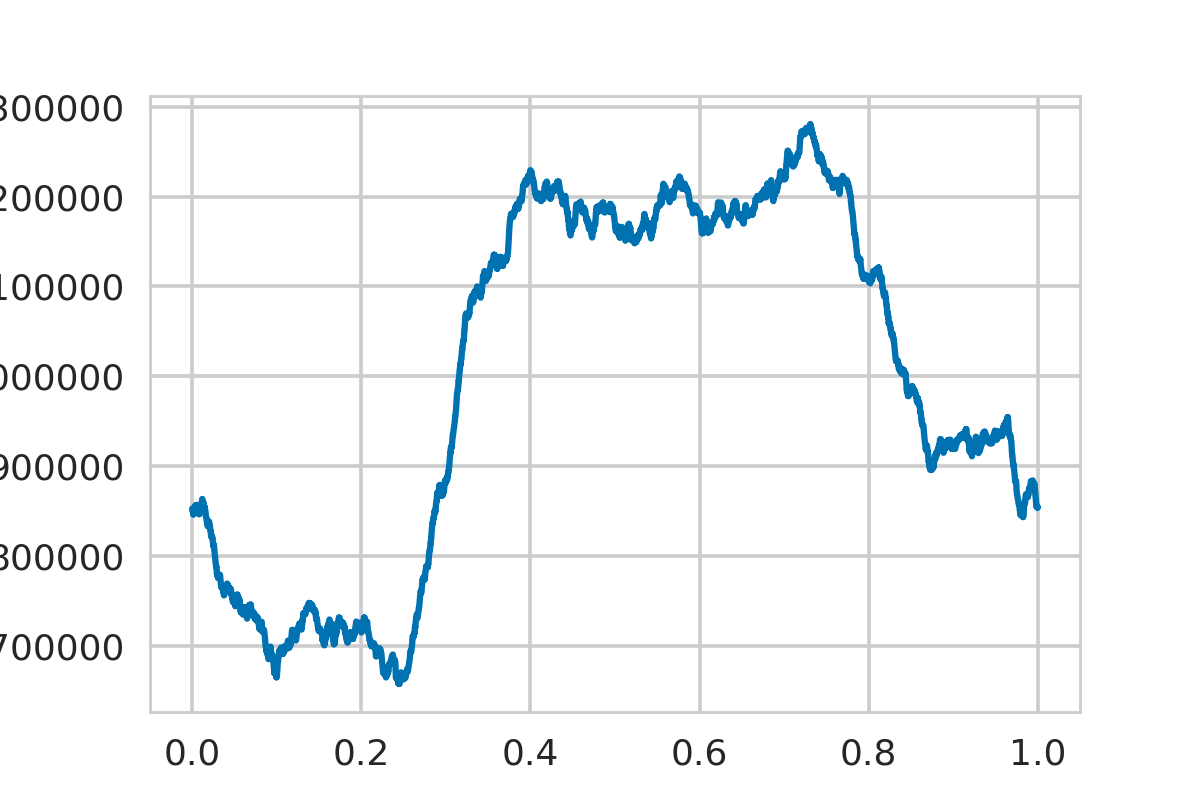

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(lc.time, lc.countrate)

Let's simulate from Poisson noise to make our two light curves for the cross spectrum:

In [7]:
counts1 = rng.poisson(lc.counts)
counts2 = rng.poisson(lc.counts)

lc1 = Lightcurve(lc.time, counts1)
lc2 = Lightcurve(lc.time, counts2)

<IPython.core.display.Javascript object>


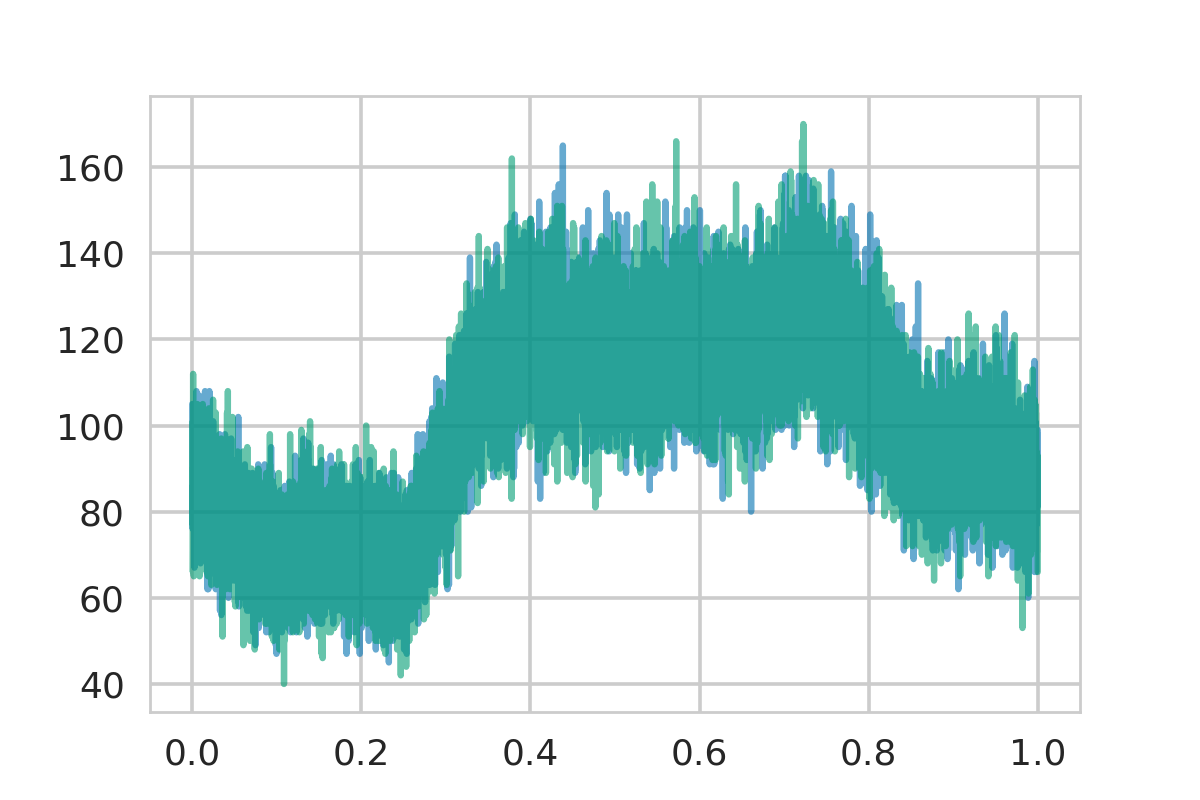

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(lc1.time, lc1.counts, alpha=0.6)
ax.plot(lc2.time, lc2.counts, alpha=0.6)


Okay, cool. Let's make the cross spectrum by hand so that we can look at each of the steps.

In [9]:
fourier1 = scipy.fftpack.fft(lc1.counts)
fourier2 = scipy.fftpack.fft(lc2.counts)

freqs = scipy.fftpack.fftfreq(npoints, lc1.dt)

fourier1 = fourier1[freqs>0]
fourier2 = fourier2[freqs>0]

freqs = freqs[freqs > 0]

In [10]:
csd_real = fourier1.real * fourier2.real
csd_imag = fourier1.imag * fourier2.imag

csd = csd_real + csd_imag

Let's plot the two Fourier components:

<IPython.core.display.Javascript object>


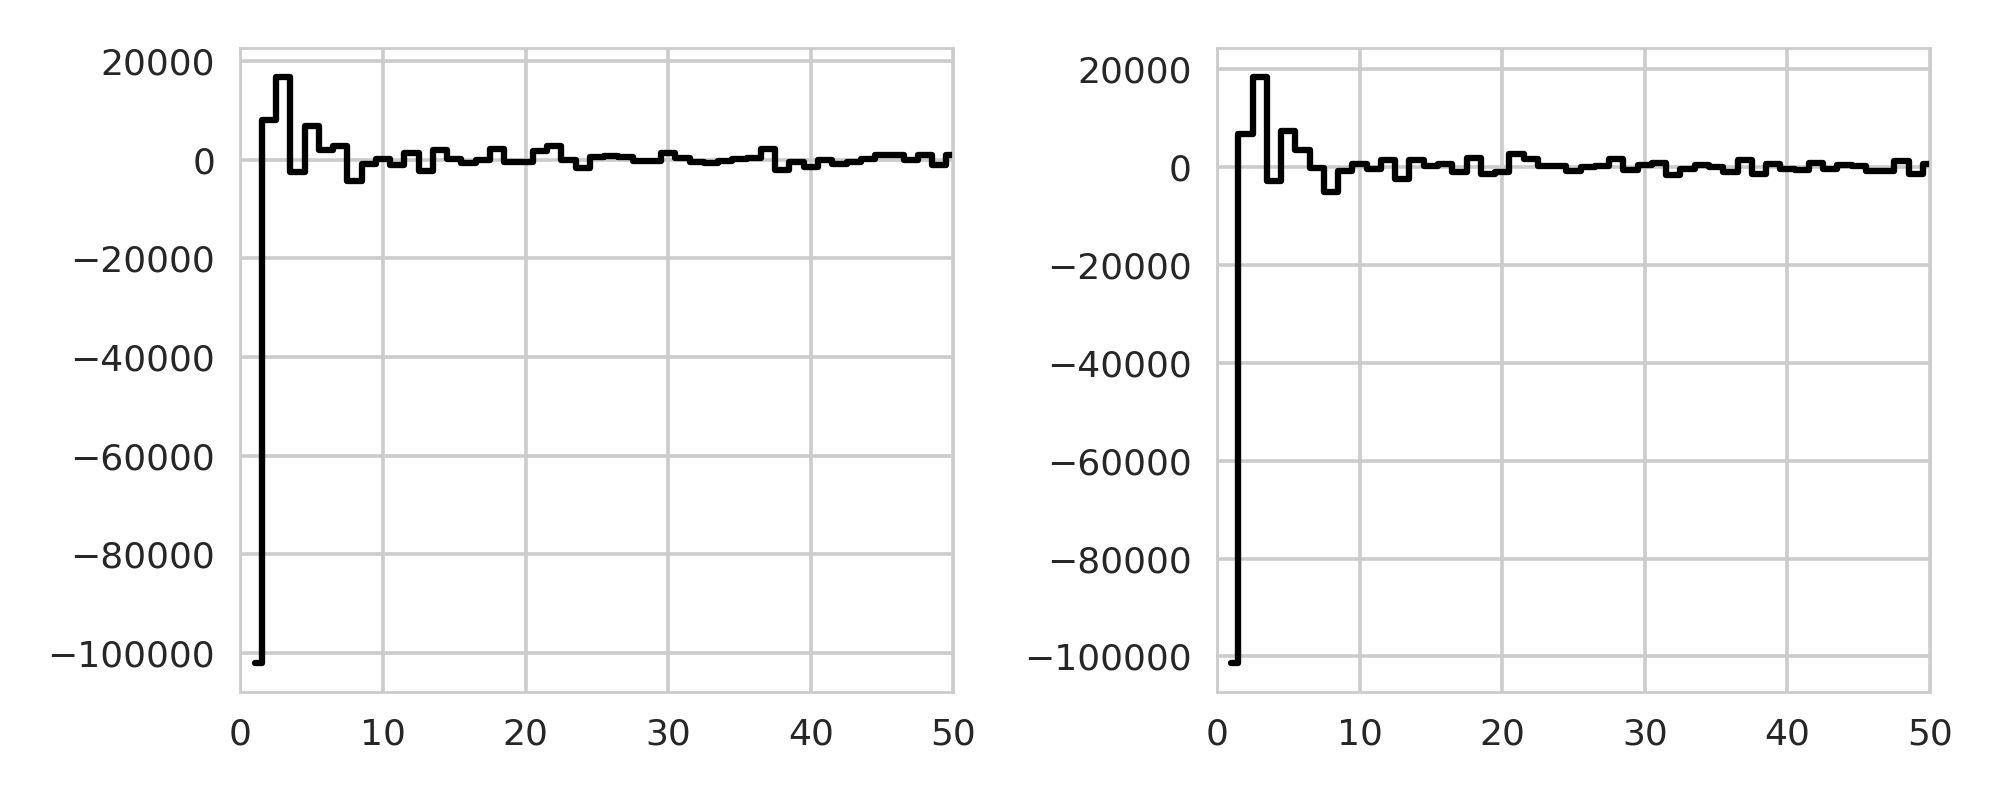

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(freqs, fourier1.real, linestyle="steps-mid", color="black")
ax2.plot(freqs, fourier2.real, linestyle="steps-mid", color="black")
ax1.set_xlim(0, 50)
ax2.set_xlim(0, 50)
plt.tight_layout()

<IPython.core.display.Javascript object>


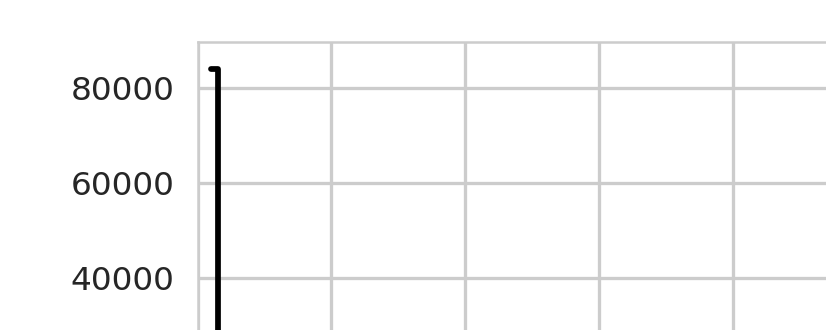

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(freqs, fourier1.imag, linestyle="steps-mid", color="black")
ax2.plot(freqs, fourier2.imag, linestyle="steps-mid", color="black")
ax1.set_xlim(0, 50)
ax2.set_xlim(0, 50)
plt.tight_layout()

Okay, cool. We kind of want to know what the statistical distribution in the red noise part is, so let's simulate a whole lot of red noise light curves and build the distributions for each bin.

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
npoints = 10000
dt = 0.0001
rng = np.random.RandomState(100)
sim = Simulator(dt=dt, N=npoints, mean=100, rms=0.2, random_state=rng)

nsim = 2000

fourier1_all, fourier2_all, csd_all, csd_normed_all = [], [], [], []
lc1_counts_all, lc2_counts_all = [], []
lc1_all, lc2_all = [], []
ps1_all, ps2_all = [], []

for i in range(nsim):
    #print(i)
    lc = sim.simulate(2)
    
    try:
        counts1 = rng.poisson(lc.counts)
        counts2 = rng.poisson(lc.counts)
    except ValueError:
        continue
        
    lc1 = Lightcurve(lc.time, counts1)
    lc2 = Lightcurve(lc.time, counts2)
    
    lc1_counts_all.append(np.sum(lc1.counts))
    lc2_counts_all.append(np.sum(lc2.counts))
    
    lc1_all.append(lc1)
    lc2_all.append(lc2)
    
    fourier1 = scipy.fftpack.fft(lc1.counts)
    fourier2 = scipy.fftpack.fft(lc2.counts)

    freqs = scipy.fftpack.fftfreq(npoints, lc1.dt)

    fourier1 = fourier1[freqs>0]
    fourier2 = fourier2[freqs>0]

    freqs = freqs[freqs > 0]
    
    csd_real = fourier1.real * fourier2.real
    csd_imag = fourier1.imag * fourier2.imag

    csd = csd_real + csd_imag
    
    mean_nphot = np.sqrt(np.sum(lc1.counts)*np.sum(lc2.counts))

    ps1 = Powerspectrum(lc1, norm="leahy")
    ps2 = Powerspectrum(lc2, norm="leahy")
    
    ps1_all.append(ps1)
    ps2_all.append(ps2)
    fourier1_all.append(fourier1[:1500])
    fourier2_all.append(fourier2[:1500])
    csd_all.append(csd[:1500])
    csd_normed_all.append(2.*csd[:1500]/mean_nphot)


In [16]:
fourier1_all = np.array(fourier1_all)
fourier2_all = np.array(fourier2_all)
csd_all = np.array(csd_all)
lc1_counts_all = np.array(lc1_counts_all)
lc2_counts_all = np.array(lc2_counts_all)

Let's make an averaged periodogram so we can estimate what the power spectrum looks like:

In [17]:
from stingray import AveragedPowerspectrum

In [18]:
avg_ps1 = AveragedPowerspectrum(lc1_all, segment_size=lc1_all[0].tseg, norm="leahy")

In [19]:
from astropy.modeling import models

In [20]:
m = models.PowerLaw1D() + models.Const1D()
m.x_0_0.fixed=True

In [21]:
from stingray.modeling import PSDLogLikelihood, PSDParEst

In [22]:
loglike = PSDLogLikelihood(avg_ps1.freq, avg_ps1.power, model=m, m=avg_ps1.m)

In [23]:
parest = PSDParEst(avg_ps1, max_post=False)

In [24]:
res = parest.fit(loglike, [3.24e4, 2, 2])

In [25]:
m.amplitude_0 = res.p_opt[0]
m.alpha_0 = res.p_opt[1]
m.amplitude_1 = res.p_opt[2]

In [26]:
mps = m(avg_ps1.freq)

<IPython.core.display.Javascript object>


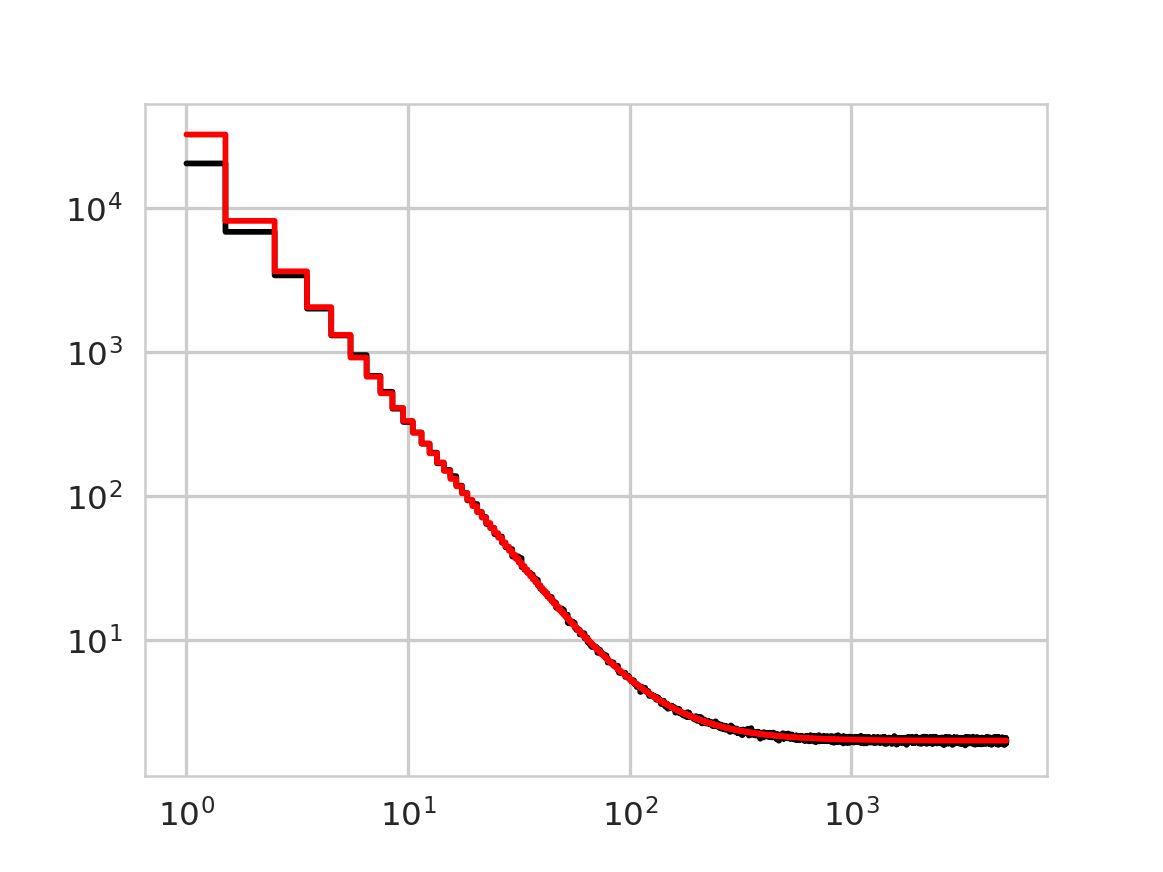

In [27]:
plt.figure()
plt.loglog(avg_ps1.freq, avg_ps1.power, linestyle="steps-mid", color="black")
plt.loglog(avg_ps1.freq, mps, linestyle="steps-mid", color="red")

In [28]:
fourier1_all.shape

(5000, 1500)

In [29]:
len(fourier1_all[:,0])

5000

<IPython.core.display.Javascript object>


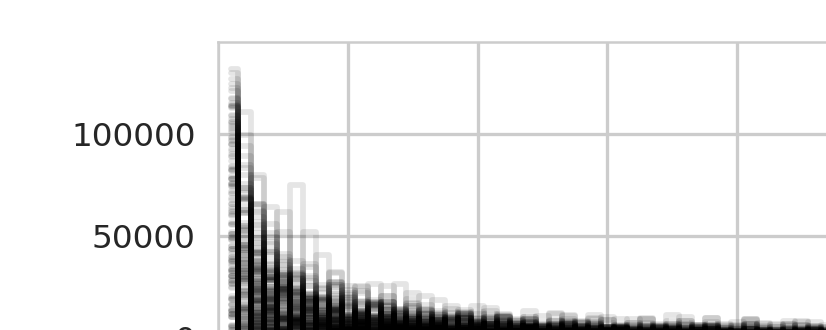

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

for f1, f2 in zip(fourier1_all[:300], fourier2_all[:300]):
    ax1.plot(freqs[:1500], f1.real, linestyle="steps-mid", color="black", alpha=0.1)
    ax2.plot(freqs[:1500], f2.real, linestyle="steps-mid", color="black", alpha=0.1)
ax1.set_xlim(0, 50)
ax2.set_xlim(0, 50)
plt.tight_layout()

In [31]:
fourier1_all[:,10].shape

(5000,)

In [34]:
for i in range(50):
    f = fourier1_all[:,i]
    print("shape: " + str(f.shape))
    print("mean: " + str(np.mean(f.real)))
    var_data = np.var(f.real)
    var_model = mps[i]/4.0*np.mean(lc1_counts_all)
    print("std: " + str(var_data))
    print("model value: " + str(mps[i]))
    print("var(model): " + str(var_model))
    print("ratio: " + str(var_data/var_model))
    print("\n")

shape: (5000,)
mean: 1261.865816475821
std: 5015108362.617442
model value: 32410.302137742532
var(model): 8102698967.4508095
ratio: 0.618942945154884


shape: (5000,)
mean: 57.24731940942705
std: 1762787254.4116304
model value: 8181.451662476168
var(model): 2045394074.268626
ratio: 0.8618325811088273


shape: (5000,)
mean: -168.86842970799938
std: 854939150.4677603
model value: 3657.5798475706956
var(model): 914408891.6026444
ratio: 0.9349637326572207


shape: (5000,)
mean: 149.49802725603402
std: 500381144.0614526
model value: 2066.3908206328315
var(model): 516605574.90432876
ratio: 0.9685941622951305


shape: (5000,)
mean: -385.1635198951715
std: 325933646.8982797
model value: 1327.2585633062567
var(model): 331819695.6244396
ratio: 0.9822613039437483


shape: (5000,)
mean: -449.6859098964588
std: 238565255.21745673
model value: 924.6217789241749
var(model): 231158966.1068577
ratio: 1.0320398089476457


shape: (5000,)
mean: 274.2148176004537
std: 174820848.37454352
model value: 681.27

Okay, it looks like mean of my distributions is still zero, but the width changes as a function of frequency.

Let's plot some of those distributions:


In [32]:
#norm1 = scipy.stats.norm(0, 85*np.sqrt(np.sum(lc1.counts))/2)
#norm2 = scipy.stats.norm(0, 30*np.sqrt(np.sum(lc1.counts))/2)
#norm3 = scipy.stats.norm(0, 1.5*np.sqrt(np.sum(lc1.counts))/2)

norm1 = scipy.stats.norm(0, np.sqrt(mps[1]/4.0*np.mean(lc1_counts_all)))
norm2 = scipy.stats.norm(0, np.sqrt(mps[5]/4.0*np.mean(lc1_counts_all)))
norm3 = scipy.stats.norm(0, np.sqrt(mps[499]/4.0*np.mean(lc1_counts_all)))

u = np.linspace(-150000, 150000, 100000)
prob_norm1 = norm1.pdf(u)
prob_norm2 = norm2.pdf(u)
prob_norm3 = norm3.pdf(u)

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:82: RuntimeWarning: underflow encountered in true_divide
  return np.exp(-x**2/2.0) / _norm_pdf_C


In [33]:
print(np.sqrt(mps[1]))
print(np.sqrt(mps[5]))
print(np.sqrt(mps[499]))

90.45707915605007
30.40901460054215
1.4627392395581167


<IPython.core.display.Javascript object>


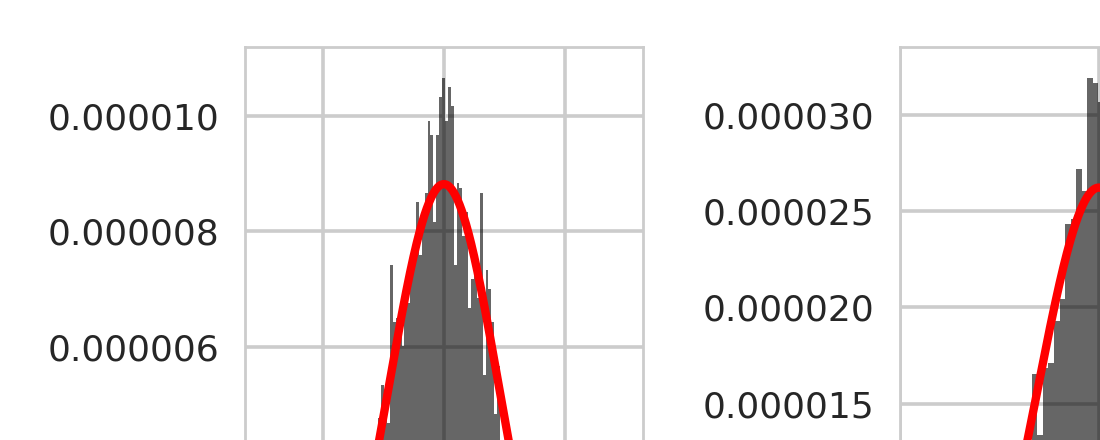

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
ax1.hist(fourier1_all[:,1].real, bins=100, color="black", alpha=0.6, normed=True)
ax2.hist(fourier1_all[:,5].real, bins=100, color="black", alpha=0.6, normed=True)
ax3.hist(fourier1_all[:,499].real, bins=100, color="black", alpha=0.6, normed=True)

ax1.plot(u, prob_norm1, lw=3, color="red")
ax2.plot(u, prob_norm2, lw=3, color="red")
ax3.plot(u, prob_norm3, lw=3, color="red")

ax2.set_xlim(-50000, 50000)
ax3.set_xlim(-3000, 3000)

plt.tight_layout()


How does this variance compare if I don't have any white noise in my data?

In [57]:
nsim = 5000

fourier1_all_rn = []
lc1_counts_all_rn = []
lc1_all_rn = []
ps1_all_rn = []

for i in range(nsim):
    print(i)
    lc = sim.simulate(2)
            
    lc1_counts_all_rn.append(np.sum(lc.counts))
    
    lc1_all_rn.append(lc)
    
    fourier1 = scipy.fftpack.fft(lc.counts)
    freqs = scipy.fftpack.fftfreq(npoints, lc.dt)
    fourier1 = fourier1[freqs>0]
    freqs = freqs[freqs > 0]

    ps1 = Powerspectrum(lc, norm="leahy")
    
    ps1_all_rn.append(ps1)
    
    fourier1_all_rn.append(fourier1[:1500])


0
1
2
3
4
5
6


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

7
8
9
10
11
12
13
14
15
16


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

17
18
19
20
21
22
23
24
25
26
27


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

28
29
30
31
32
33
34
35
36


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

37
38
39
40
41
42
43
44
45


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

46
47
48
49
50
51
52
53
54
55
56


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

57
58
59
60
61
62
63
64
65
66


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

67
68
69
70
71
72
73
74
75
76
77
78


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

79
80
81
82
83
84
85
86
87
88
89


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

90
91
92
93
94
95
96
97
98


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

99
100
101
102
103
104
105
106
107
108


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

109
110
111
112
113
114
115
116


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

117
118
119
120
121
122
123
124
125
126
127
128
129


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

130
131
132
133
134
135
136
137


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

138
139
140
141
142
143
144
145
146
147
148


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

149
150
151
152
153
154
155
156


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

157
158
159
160
161
162
163
164
165


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

166
167
168
169
170
171
172
173
174
175
176
177


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

178
179
180
181
182
183
184
185
186
187


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

188
189
190
191
192
193
194
195
196
197


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

198
199
200
201
202
203
204
205
206
207
208


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

209
210
211
212
213
214
215
216
217
218
219
220


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

221
222
223
224
225
226
227
228
229
230
231


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

232
233
234
235
236
237
238
239
240
241
242


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

243
244
245
246
247
248
249
250
251
252
253


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

254
255
256
257
258
259
260
261
262
263
264


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

265
266
267
268
269
270
271
272
273
274
275


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

276
277
278
279
280
281
282
283
284
285
286


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

287
288
289
290
291
292
293
294
295
296
297


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

298
299
300
301
302
303
304
305
306
307
308


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

309
310
311
312
313
314
315
316


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

317
318
319
320
321
322
323
324
325
326


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

327
328
329
330
331
332
333
334
335
336


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

337
338
339
340
341
342
343
344
345
346
347


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

348
349
350
351
352
353
354
355
356
357
358


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

359
360
361
362
363
364
365
366
367
368


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

369
370
371
372
373
374
375
376
377
378


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

379
380
381
382
383
384
385
386
387
388
389


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

390
391
392
393
394
395
396
397
398
399


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

400
401
402
403
404
405
406
407
408
409
410


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

411
412
413
414
415
416
417
418
419
420
421


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

422
423
424
425
426
427
428
429


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

430
431
432
433
434
435
436
437


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

438
439
440
441
442
443
444
445
446
447
448
449


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

450
451
452
453
454
455
456
457
458
459


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

460
461
462
463
464
465
466
467
468
469


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

470
471
472
473
474


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

475
476
477
478
479
480
481
482


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

483
484
485
486
487
488
489
490
491
492


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

493
494
495
496
497
498
499
500
501
502
503


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

504
505
506
507
508
509
510
511
512
513
514


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

515
516
517
518
519
520
521
522
523
524
525


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

526
527
528
529
530
531
532
533
534
535
536


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

537
538
539
540
541
542
543
544
545
546
547


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

548
549
550
551
552
553
554
555
556
557


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

558
559
560
561
562
563
564
565
566
567
568


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

569
570
571
572
573
574
575


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

576
577
578
579
580
581


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

582
583
584
585
586
587
588
589
590
591
592


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

593
594
595
596
597
598
599
600
601


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

602
603
604
605
606
607
608
609
610
611


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

612
613
614
615
616
617
618
619
620
621
622
623


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

624
625
626
627
628
629
630
631
632
633
634
635


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

636
637
638
639
640
641
642
643
644


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

645
646
647
648
649
650
651
652


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

653
654
655
656
657
658
659
660
661
662


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

663
664
665
666
667
668
669
670
671


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

672
673
674
675
676
677
678
679
680


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

681
682
683
684
685
686
687
688
689
690
691
692


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

693
694
695
696
697
698
699
700
701
702
703
704


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

705
706
707
708
709
710
711
712
713
714


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

715
716
717
718
719
720
721
722
723
724
725
726
727


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

728
729
730
731
732
733
734
735
736
737
738
739


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

740
741
742
743
744
745
746
747
748
749
750


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

751
752
753
754
755
756
757
758
759
760
761
762


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

763
764
765
766
767
768
769
770
771
772
773
774
775


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

776
777
778
779
780
781
782
783
784
785
786
787
788
789


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

790
791
792
793
794
795
796
797
798


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

799
800
801
802
803
804
805
806
807
808
809
810


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

811
812
813
814
815
816
817
818
819
820
821
822


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

823
824
825
826
827
828
829
830
831
832
833
834


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

835
836
837
838
839
840
841
842
843
844
845
846
847


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

848
849
850
851
852
853
854
855
856
857
858
859
860
861


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

862
863
864
865
866
867
868
869
870
871
872
873
874


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

875
876
877
878
879
880
881
882
883
884
885
886
887


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

888
889
890
891
892
893
894
895
896


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

897
898
899
900
901
902
903
904
905
906
907


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

908
909
910
911
912
913
914
915
916


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

917
918
919
920
921
922
923


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

924
925
926
927
928
929
930
931
932
933


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

934
935
936
937
938
939
940
941
942
943


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

944
945
946
947
948
949
950
951
952
953
954


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

955
956
957
958
959
960
961
962
963
964


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

965
966
967
968
969
970
971
972
973
974
975
976


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

977
978
979
980
981
982
983
984
985
986
987
988


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

989
990
991
992
993
994
995
996
997
998
999
1000
1001


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1046
1047
1048
1049
1050
1051
1052
1053
1054


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1129
1130
1131
1132
1133
1134
1135
1136


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1137
1138
1139
1140
1141
1142
1143
1144


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1207
1208
1209
1210
1211
1212
1213
1214


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1215
1216
1217
1218
1219
1220
1221
1222


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1234
1235
1236
1237
1238
1239


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1240
1241
1242
1243
1244
1245
1246


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1324
1325
1326
1327
1328
1329
1330
1331
1332
1333


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1384
1385
1386
1387
1388
1389


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1390
1391
1392
1393
1394
1395
1396
1397


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1398
1399
1400
1401
1402
1403


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1404
1405
1406
1407
1408


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1409
1410
1411
1412
1413
1414


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1415
1416
1417
1418


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1419
1420
1421
1422
1423


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1424
1425
1426
1427


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1428
1429
1430
1431
1432
1433
1434
1435
1436


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1437
1438
1439
1440
1441
1442
1443
1444
1445
1446


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1481
1482
1483
1484
1485
1486
1487
1488
1489
1490


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1491
1492
1493
1494
1495
1496
1497
1498


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1499
1500
1501
1502
1503
1504
1505


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1506
1507
1508
1509
1510
1511
1512
1513
1514
1515


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1539
1540
1541
1542
1543
1544
1545
1546
1547
1548


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1561
1562
1563
1564
1565
1566
1567
1568
1569
1570


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1571
1572
1573
1574
1575
1576
1577


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1578
1579
1580
1581


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1582
1583
1584
1585
1586
1587


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1588
1589
1590
1591
1592
1593


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1594
1595
1596
1597
1598
1599


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1600
1601
1602
1603
1604


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1605
1606
1607
1608
1609


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1610
1611
1612
1613
1614


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1615
1616
1617
1618
1619
1620


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1621
1622
1623
1624
1625
1626


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1627
1628
1629
1630
1631


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1632
1633
1634
1635
1636
1637
1638
1639
1640


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1665
1666
1667
1668
1669
1670
1671
1672
1673
1674


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1724
1725
1726
1727


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1728
1729
1730
1731
1732


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1733
1734
1735
1736
1737
1738
1739


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1844
1845
1846
1847
1848
1849


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1850
1851
1852
1853
1854
1855
1856
1857
1858
1859


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1977
1978
1979
1980
1981
1982
1983
1984
1985
1986


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

1987
1988
1989
1990
1991
1992
1993
1994
1995
1996


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2106
2107
2108
2109
2110
2111
2112
2113
2114
2115


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2393
2394
2395
2396
2397
2398
2399
2400
2401
2402


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2516
2517
2518
2519
2520
2521
2522
2523
2524
2525


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2526
2527
2528
2529
2530
2531
2532


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2559
2560
2561
2562
2563
2564
2565
2566
2567


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2580
2581
2582
2583
2584
2585
2586
2587
2588
2589


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2628
2629
2630
2631
2632
2633
2634
2635
2636


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2760
2761
2762
2763
2764
2765
2766


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2867
2868
2869
2870
2871
2872
2873
2874
2875


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2876
2877
2878
2879


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2950
2951
2952
2953
2954
2955
2956
2957


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2958
2959
2960
2961
2962
2963
2964
2965
2966
2967


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2979
2980
2981
2982
2983
2984
2985
2986
2987
2988


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

2989
2990
2991
2992
2993
2994
2995
2996
2997
2998


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3036
3037
3038
3039
3040
3041
3042
3043


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3096
3097
3098
3099
3100
3101
3102
3103


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3104
3105
3106
3107
3108
3109
3110
3111


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3112
3113
3114
3115
3116


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3117
3118
3119
3120
3121
3122
3123
3124
3125
3126


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3127
3128
3129
3130
3131
3132
3133


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3134
3135
3136
3137


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3138
3139
3140
3141
3142
3143
3144
3145
3146
3147


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3148
3149
3150
3151
3152
3153
3154


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3155
3156
3157
3158
3159
3160
3161


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3162
3163
3164
3165
3166
3167


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3168
3169
3170
3171
3172
3173
3174
3175


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3176
3177
3178
3179


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3229
3230
3231
3232
3233
3234
3235
3236
3237
3238


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3286
3287
3288
3289
3290
3291
3292
3293
3294
3295


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3296
3297
3298
3299
3300
3301
3302
3303
3304
3305


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3380
3381
3382
3383
3384
3385
3386
3387


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3411
3412
3413
3414
3415
3416
3417
3418
3419


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3420
3421
3422
3423
3424
3425
3426
3427
3428
3429


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3542
3543
3544
3545
3546
3547
3548
3549
3550
3551


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3564
3565
3566
3567
3568
3569
3570
3571
3572
3573


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3645
3646
3647
3648
3649
3650
3651
3652


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3653
3654
3655
3656
3657


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3771
3772
3773
3774
3775
3776
3777
3778
3779
3780


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3819
3820
3821
3822
3823
3824
3825
3826
3827


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3828
3829
3830
3831
3832
3833
3834
3835
3836
3837


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3862
3863
3864
3865
3866
3867
3868
3869
3870
3871


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3872
3873
3874
3875
3876
3877
3878
3879
3880


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3881
3882
3883
3884
3885
3886
3887
3888


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3900
3901
3902
3903
3904
3905
3906
3907
3908


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

3909
3910
3911
3912
3913
3914
3915
3916
3917
3918


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3944
3945
3946
3947
3948
3949
3950
3951
3952
3953


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3978
3979
3980
3981
3982
3983
3984
3985


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3986
3987
3988
3989
3990


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4002
4003
4004
4005
4006
4007
4008
4009
4010
4011


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4012
4013
4014
4015
4016
4017
4018
4019
4020
4021


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4022
4023
4024
4025
4026
4027
4028
4029
4030
4031


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4032
4033
4034
4035
4036
4037
4038
4039
4040


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4041
4042
4043
4044
4045
4046
4047
4048


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4072
4073
4074
4075
4076
4077
4078
4079
4080
4081


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4163
4164
4165
4166
4167
4168
4169
4170
4171
4172


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4186
4187
4188
4189
4190
4191
4192
4193
4194


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4217
4218
4219
4220
4221
4222
4223
4224
4225
4226


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4227
4228
4229
4230
4231
4232
4233
4234
4235


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4273
4274
4275
4276
4277
4278
4279
4280
4281


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4296
4297
4298
4299
4300
4301
4302
4303
4304
4305


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4306
4307
4308
4309
4310
4311
4312


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4337
4338
4339
4340
4341
4342
4343
4344
4345
4346


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4382
4383
4384
4385
4386
4387
4388
4389
4390


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4391
4392
4393
4394
4395
4396
4397
4398
4399
4400


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4401
4402
4403
4404
4405
4406
4407
4408
4409


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4410
4411
4412
4413
4414


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4462
4463
4464
4465
4466
4467
4468
4469
4470
4471


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4524
4525
4526
4527
4528
4529
4530
4531
4532


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4569
4570
4571
4572
4573
4574
4575
4576
4577


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4636
4637
4638
4639
4640
4641
4642
4643
4644


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4753
4754
4755
4756
4757
4758
4759
4760
4761
4762


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
4785


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4786
4787
4788
4789
4790
4791
4792
4793
4794
4795


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4834
4835
4836
4837
4838
4839
4840
4841
4842
4843


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4856
4857
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4869
4870
4871
4872
4873
4874


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4875
4876
4877
4878
4879
4880
4881
4882


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4894
4895
4896
4897
4898
4899
4900
4901


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like you

4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

4990
4991
4992
4993
4994
4995
4996
4997
4998
4999


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson 

In [58]:
fourier1_all_rn = np.array(fourier1_all_rn)
lc1_counts_all_rn = np.array(lc1_counts_all_rn)

avg_ps1_rn = AveragedPowerspectrum(lc1_all_rn, segment_size=lc1_all_rn[0].tseg, norm="leahy")

mrn = models.PowerLaw1D() + models.Const1D()
mrn.x_0_0.fixed=True

loglike_rn = PSDLogLikelihood(avg_ps1_rn.freq, avg_ps1_rn.power, model=mrn, m=avg_ps1_rn.m)

parest_rn = PSDParEst(avg_ps1_rn, max_post=False)
res_rn = parest.fit(loglike_rn, [3.24e4, 2, 2])

mrn.amplitude_0 = res_rn.p_opt[0]
mrn.alpha_0 = res_rn.p_opt[1]
mrn.amplitude_1 = res_rn.p_opt[2]

mps_rn = mrn(avg_ps1_rn.freq)

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is not poisson.The errors in the Powerspectrum will be incorrect.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/utils.py:89: UserWarning: SIMON says: Looks like your lightcurve statistic is 

<IPython.core.display.Javascript object>


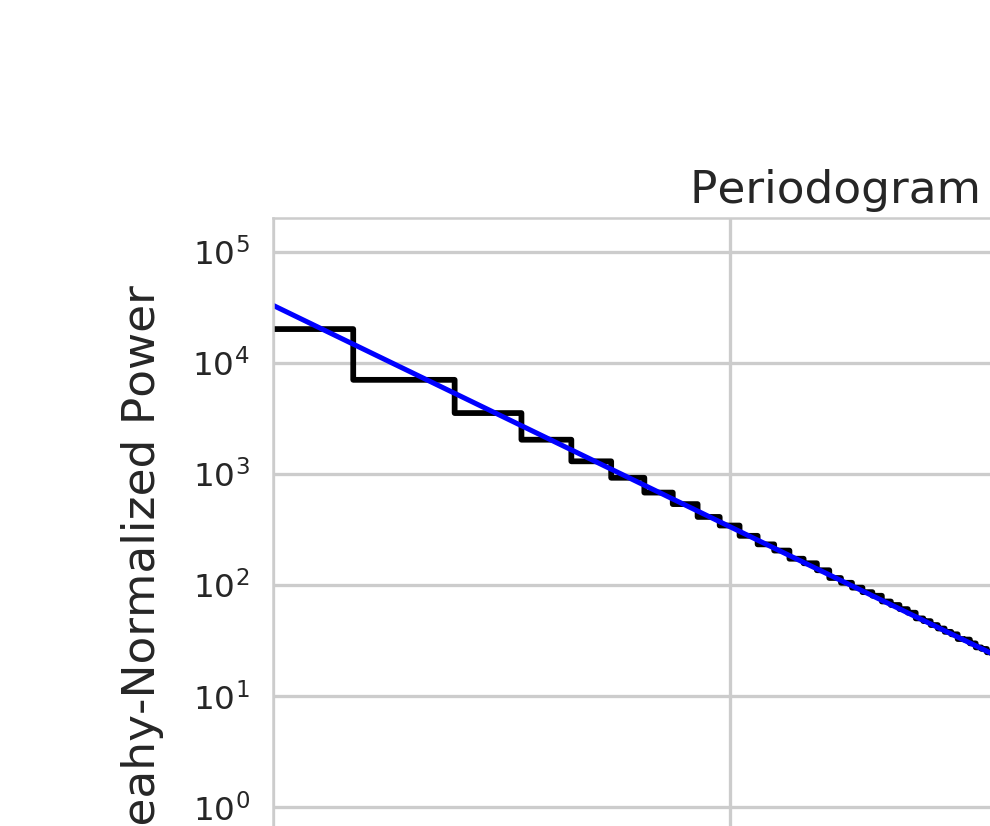

In [59]:
parest_rn.plotfits(res_rn)

In [60]:
mps_rn_wn = mps_rn + 2.0

<IPython.core.display.Javascript object>


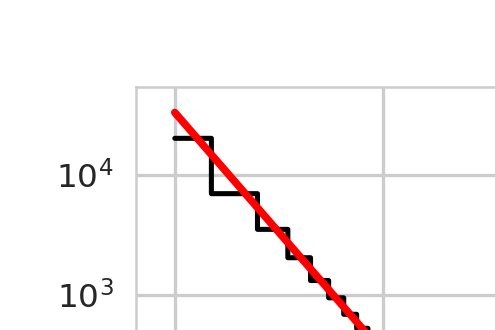

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.loglog(avg_ps1.freq, avg_ps1.power, lw=2, color="black", linestyle="steps-mid")
ax.plot(avg_ps1.freq, mps_rn_wn, lw=3, color="red")

In [62]:
mps_rn/mps_rn_wn

array([9.99939241e-01, 9.99758046e-01, 9.99457131e-01, ...,
       6.84066299e-04, 6.83789556e-04, 6.83512979e-04])

In [63]:
for i in range(50):
    f = fourier1_all[:,i]
    print("shape: " + str(f.shape))
    print("mean: " + str(np.mean(f.real)))
    var_data = np.var(f.real)
    var_model = mps_rn[i]/4.0*np.mean(lc1_counts_all) + np.mean(lc1_counts_all)/2.0
    print("std: " + str(np.sqrt(var_data)))
    print("var(model): " + str(np.sqrt(var_model)))
    print("ratio: " + str(var_data/var_model))
    print("\n")

shape: (5000,)
mean: 1261.8658164758212
std: 70817.42979392462
var(model): 90715.46100173282
ratio: 0.6094213957620278


shape: (5000,)
mean: 57.24731940942742
std: 41985.5600702388
var(model): 45459.214209612306
ratio: 0.8530137915877265


shape: (5000,)
mean: -168.86842970799935
std: 29239.342510866423
var(model): 30348.74827631967
ratio: 0.928225806300798


shape: (5000,)
mean: 149.49802725603402
std: 22369.200791746065
var(model): 22786.616693519394
ratio: 0.9636986308691455


shape: (5000,)
mean: -385.16351989517136
std: 18053.63251255214
var(model): 18246.802502080238
ratio: 0.978939050683327


shape: (5000,)
mean: -449.6859098964588
std: 15445.557782658958
var(model): 15219.254734628314
ratio: 1.02996014734207


shape: (5000,)
mean: 274.2148176004538
std: 13221.983526481325
var(model): 13056.365448539458
ratio: 1.0255306117303147


shape: (5000,)
mean: 101.31866823394067
std: 11404.443129607387
var(model): 11434.151779965669
ratio: 0.994810274368649


shape: (5000,)
mean: 37.873

Let's do pure white noise for comparison:

In [64]:
nsim = 5000

fourier1_all_wn = []
lc1_counts_all_wn = []
lc1_all_wn = []
ps1_all_wn = []

time = lc.time

for i in range(nsim):
    print(i)
    counts = np.random.poisson(100, size=time.shape[0])
    lc = Lightcurve(time, counts)
            
    lc1_counts_all_wn.append(np.sum(lc.counts))
    
    lc1_all_wn.append(lc)
    
    fourier1 = scipy.fftpack.fft(lc.counts)
    freqs = scipy.fftpack.fftfreq(npoints, lc.dt)
    fourier1 = fourier1[freqs>0]
    freqs = freqs[freqs > 0]

    ps1 = Powerspectrum(lc, norm="leahy")
    
    ps1_all_wn.append(ps1)
    
    fourier1_all_wn.append(fourier1[:1500])



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072


3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720


In [65]:
fourier1_all_wn = np.array(fourier1_all_wn)

In [69]:
for i in range(50):
    f = fourier1_all_wn[:,i]
    print("shape: " + str(f.shape))
    print("mean: " + str(np.mean(f.real)))
    var_data = np.var(f.real)
    var_model = 2.0/4.0*np.mean(lc1_counts_all)
    print("std: " + str(np.sqrt(var_data)))
    print("var(model): " + str(np.sqrt(var_model)))
    print("ratio: " + str(var_data/var_model))
    print("\n")

shape: (5000,)
mean: 0.7541462373725364
std: 710.5150645591411
var(model): 707.1121671276771
ratio: 1.0096479331562769


shape: (5000,)
mean: -5.459070325330332
std: 710.489980271759
var(model): 707.1121671276771
ratio: 1.0095766444444427


shape: (5000,)
mean: 9.699252637420773
std: 698.7248775632369
var(model): 707.1121671276771
ratio: 0.976418034494467


shape: (5000,)
mean: -14.385062173594605
std: 703.1694166836967
var(model): 707.1121671276771
ratio: 0.9888793927276877


shape: (5000,)
mean: -1.353353549907828
std: 709.1807896800245
var(model): 707.1121671276771
ratio: 1.0058594618404966


shape: (5000,)
mean: 24.67701236751983
std: 712.2723485786283
var(model): 707.1121671276771
ratio: 1.0146483401495459


shape: (5000,)
mean: 20.347056134930224
std: 709.1698561631164
var(model): 707.1121671276771
ratio: 1.0058284471914314


shape: (5000,)
mean: -6.185908284005718
std: 703.2521669541654
var(model): 707.1121671276771
ratio: 0.9891121527147466


shape: (5000,)
mean: 5.707339741260

<IPython.core.display.Javascript object>


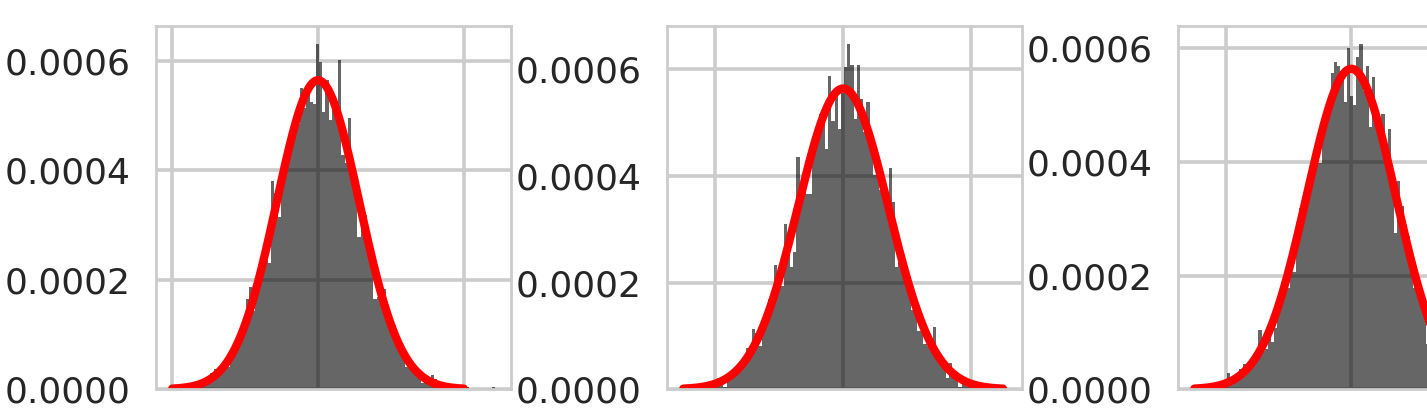

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [70]:
norm_test = scipy.stats.norm(0, np.sqrt(np.mean(lc1_counts_all_wn)/2.0))
utest = np.linspace(-2500, 2500, 10000)
prob_test = norm_test.pdf(utest)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
ax1.hist(fourier1_all_wn[:,1].real, bins=100, color="black", alpha=0.6, normed=True)
ax2.hist(fourier1_all_wn[:,10].real, bins=100, color="black", alpha=0.6, normed=True)
ax3.hist(fourier1_all_wn[:,499].real, bins=100, color="black", alpha=0.6, normed=True)

ax1.plot(utest, prob_test, lw=3, color="red")
ax2.plot(utest, prob_test, lw=3, color="red")
ax3.plot(utest, prob_test, lw=3, color="red")


plt.tight_layout()




Let's plot some of the distributions:

<IPython.core.display.Javascript object>


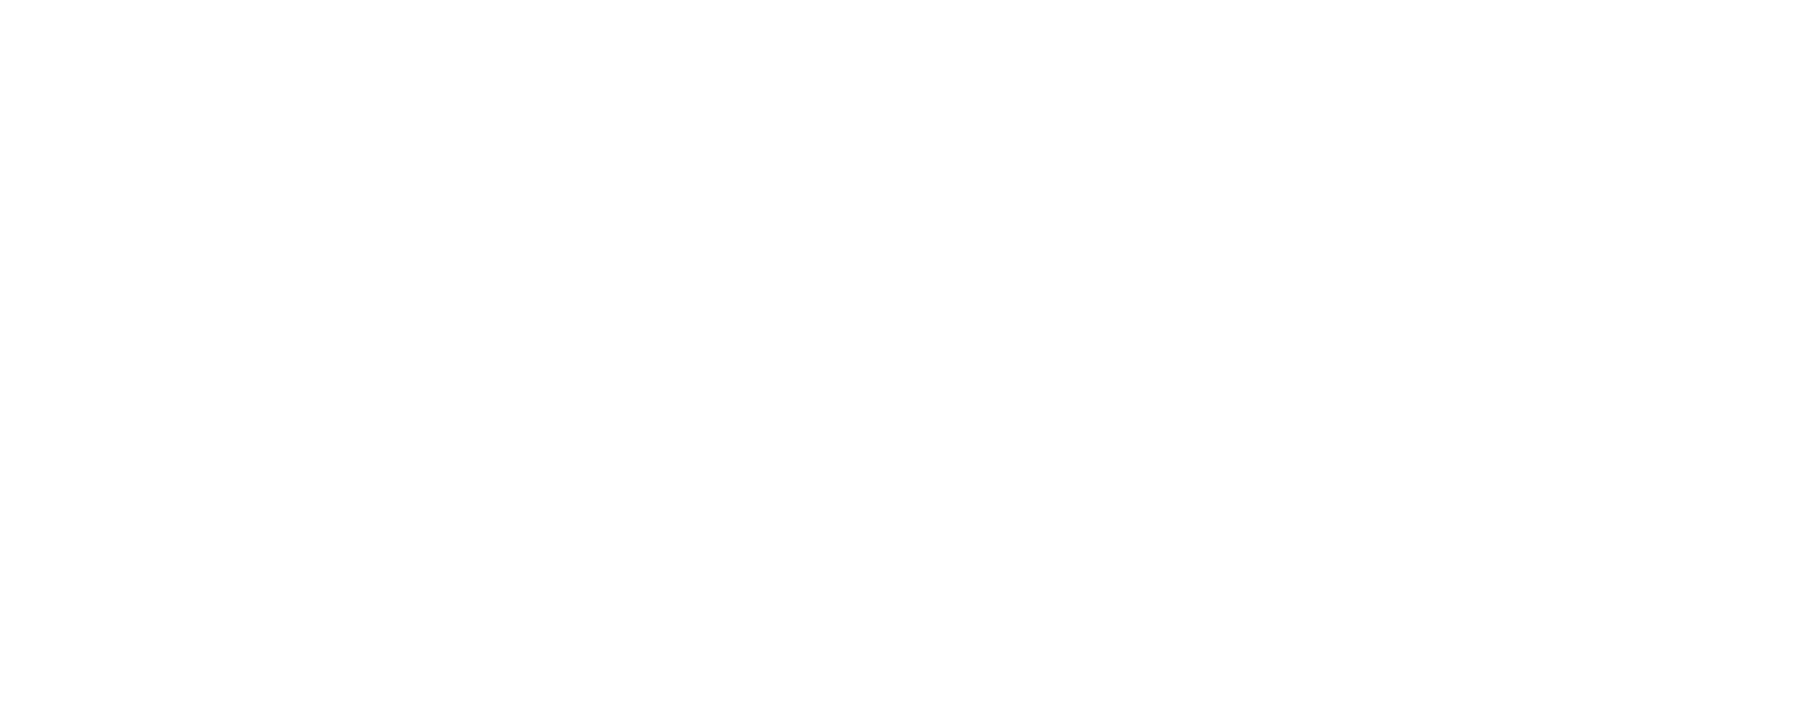

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


ValueError: x and y must have same first dimension, but have shapes (10000,) and (100000,)

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
ax1.hist(fourier1_all[:,1].real, bins=100, color="black", alpha=0.6, normed=True)
ax2.hist(fourier1_all[:,5].real, bins=100, color="black", alpha=0.6, normed=True)
ax3.hist(fourier1_all[:,499].real, bins=100, color="black", alpha=0.6, normed=True)

ax1.plot(u, prob_norm1, lw=3, color="red")
ax2.plot(u, prob_norm2, lw=3, color="red")
ax3.plot(u, prob_norm3, lw=3, color="red")

ax2.set_xlim(-50000, 50000)
ax3.set_xlim(-3000, 3000)

plt.tight_layout()



That looks approximately the way it should.

Now let's do the same for the *squared* Fourier amplitudes:

In [72]:
fourier_squared_test = []

fourier_squared_test_lc1 = []

for f1, f2 in zip(fourier1_all, fourier2_all):
    #fourier_squared_test.append(f1.conj() * f2)
    fourier_squared_test.append(f1.real * f2.real)
    fourier_squared_test_lc1.append(f1.conj()*f1)

In [73]:
fourier_squared_test = np.array(fourier_squared_test)
fourier_squared_test_lc1 = np.array(fourier_squared_test_lc1)

In [74]:
for i in range(500):
    print("mean cospectra: " + str(np.mean(fourier_squared_test[:,i].real)))
    print("std cospectra: " + str(np.std(fourier_squared_test[:,i].real)))
    print("mean psd: " + str(np.mean(fourier_squared_test_lc1[:,i].real)))
    print("std psd: " + str(np.std(fourier_squared_test_lc1[:,i].real)))

    print()

mean cospectra: 5016330806.142684
std cospectra: 4670912679.861344
mean psd: 10024791804.171534
std psd: 4937630702.566949

mean cospectra: 1761668917.818653
std cospectra: 2288014324.2440944
mean psd: 3471189657.8487625
std psd: 3071212808.774346

mean cospectra: 854649489.3790706
std cospectra: 1256186262.6223066
mean psd: 1751468443.1483243
std psd: 1854337855.013157

mean cospectra: 499663596.96045154
std cospectra: 773929368.8413962
mean psd: 1017281405.9459457
std psd: 1141857020.126048

mean cospectra: 325406761.4757556
std cospectra: 545740354.1686549
mean psd: 656942395.7693565
std psd: 800195293.9953177

mean cospectra: 238275405.8005161
std cospectra: 393043816.80886954
mean psd: 471753093.9182908
std psd: 573799180.5070827

mean cospectra: 174416252.43565962
std cospectra: 286932125.2552116
mean psd: 343924719.96156716
std psd: 420736257.12924373

mean cospectra: 129743990.12546645
std cospectra: 217518188.91825786
mean psd: 263096389.6497392
std psd: 330172128.0773376

mea

std cospectra: 1160490.7828772194
mean psd: 1860817.2211636994
std psd: 1983807.1595984895

mean cospectra: 396647.9110700583
std cospectra: 1049094.9959584512
mean psd: 1832281.641540586
std psd: 1909930.0005991529

mean cospectra: 391342.9494758529
std cospectra: 1052078.6815344
mean psd: 1778813.3837938798
std psd: 1887424.8683613937

mean cospectra: 405531.4798942179
std cospectra: 1142256.8668066075
mean psd: 1809528.3497484021
std psd: 2013805.5474997147

mean cospectra: 426655.47835667303
std cospectra: 1098121.8679548951
mean psd: 1824242.0707350816
std psd: 1954997.3449216012

mean cospectra: 383737.1102161939
std cospectra: 1047197.300453551
mean psd: 1762770.2451316703
std psd: 1846578.058478943

mean cospectra: 374479.71373052936
std cospectra: 1026332.8918068546
mean psd: 1791803.2092105388
std psd: 1921230.919167356

mean cospectra: 373841.69167573575
std cospectra: 1036118.2605610784
mean psd: 1765594.9303826832
std psd: 1875662.035247339

mean cospectra: 391335.91134558

std cospectra: 666151.988774441
mean psd: 1285388.476169627
std psd: 1323981.1065594077

mean cospectra: 141616.55200028687
std cospectra: 691796.9607972938
mean psd: 1289258.0003902595
std psd: 1307671.6002462155

mean cospectra: 143430.19381033807
std cospectra: 673051.1788990579
mean psd: 1268655.2168704926
std psd: 1322831.1205966938

mean cospectra: 148618.73294614683
std cospectra: 671055.2918155749
mean psd: 1299360.3039117772
std psd: 1316129.6608642042

mean cospectra: 171714.27878662015
std cospectra: 697672.5162972821
mean psd: 1319766.9833263962
std psd: 1358276.1328258957

mean cospectra: 144765.2140894857
std cospectra: 675355.4231518892
mean psd: 1288803.0302916814
std psd: 1312567.8701368163

mean cospectra: 130056.20809145784
std cospectra: 671476.8059962845
mean psd: 1294313.2754161644
std psd: 1308102.0484567583

mean cospectra: 132783.5009792722
std cospectra: 669737.3014455879
mean psd: 1272845.734066188
std psd: 1294833.1863227675

mean cospectra: 154444.127340222

std cospectra: 603421.4899022895
mean psd: 1180771.3166884498
std psd: 1230003.236053063

mean cospectra: 72012.07853458858
std cospectra: 612447.7264372564
mean psd: 1165145.6096697708
std psd: 1176393.0839992794

mean cospectra: 88753.28955422022
std cospectra: 600565.0701707533
mean psd: 1164982.8305235393
std psd: 1161153.1157537068

mean cospectra: 62590.440257159185
std cospectra: 587848.9927375265
mean psd: 1178793.8134407327
std psd: 1189438.6547560191

mean cospectra: 79040.6415131047
std cospectra: 568405.7303523265
mean psd: 1169914.0640752907
std psd: 1171928.9270987683

mean cospectra: 84606.62928127227
std cospectra: 585425.9502544922
mean psd: 1153464.1741940444
std psd: 1161373.6881187945

mean cospectra: 75525.70714468659
std cospectra: 618274.4534845132
mean psd: 1166146.274557776
std psd: 1163629.3811391406

mean cospectra: 75110.78237849458
std cospectra: 575298.1172282367
mean psd: 1139853.694859809
std psd: 1140907.6122788403

mean cospectra: 85048.572391748
std c

mean cospectra: 29391.045752662216
std cospectra: 531556.1302514363
mean psd: 1095217.0810703759
std psd: 1097669.6994711044

mean cospectra: 30616.983155737227
std cospectra: 525227.6450850929
mean psd: 1056972.824691767
std psd: 1063032.6899391296

mean cospectra: 40655.431310541906
std cospectra: 538637.19476586
mean psd: 1050735.073337066
std psd: 1046605.9722622123

mean cospectra: 23997.375292299796
std cospectra: 533886.6445850397
mean psd: 1056035.2013462181
std psd: 1058187.8469325532

mean cospectra: 34759.6980804216
std cospectra: 539470.2279602902
mean psd: 1071462.397814095
std psd: 1072644.6143347316

mean cospectra: 43087.72754121859
std cospectra: 525880.5276675563
mean psd: 1055368.86127793
std psd: 1016898.9047338492

mean cospectra: 28849.282062470164
std cospectra: 536026.784526004
mean psd: 1090713.274477401
std psd: 1108684.0030950548

mean cospectra: 22216.013525389695
std cospectra: 532362.6578630094
mean psd: 1097258.745610228
std psd: 1107839.6735362243

mean 

In [309]:
std1 = np.sqrt(np.mean(lc1_counts_all))
std2 = np.sqrt(np.mean(lc2_counts_all))

In [310]:
scipy.special.kn(0, 1000)

0.0

In [311]:
def bessel_probability(x, std1, std2):
    x_abs = np.abs(x)
    both_std = std1 * std2
    y = x_abs/(both_std)
    order = 0
    k = scipy.special.kn(order, y)/(np.pi*both_std)
    return k

In [312]:
u = np.linspace(-3e6, 3e6, 100000)
prob_u = bessel_probability(u, std1, std2)

In [313]:
prob_u

array([1.10578491e-08, 1.10586161e-08, 1.10593831e-08, ...,
       1.10593831e-08, 1.10586161e-08, 1.10578491e-08])

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


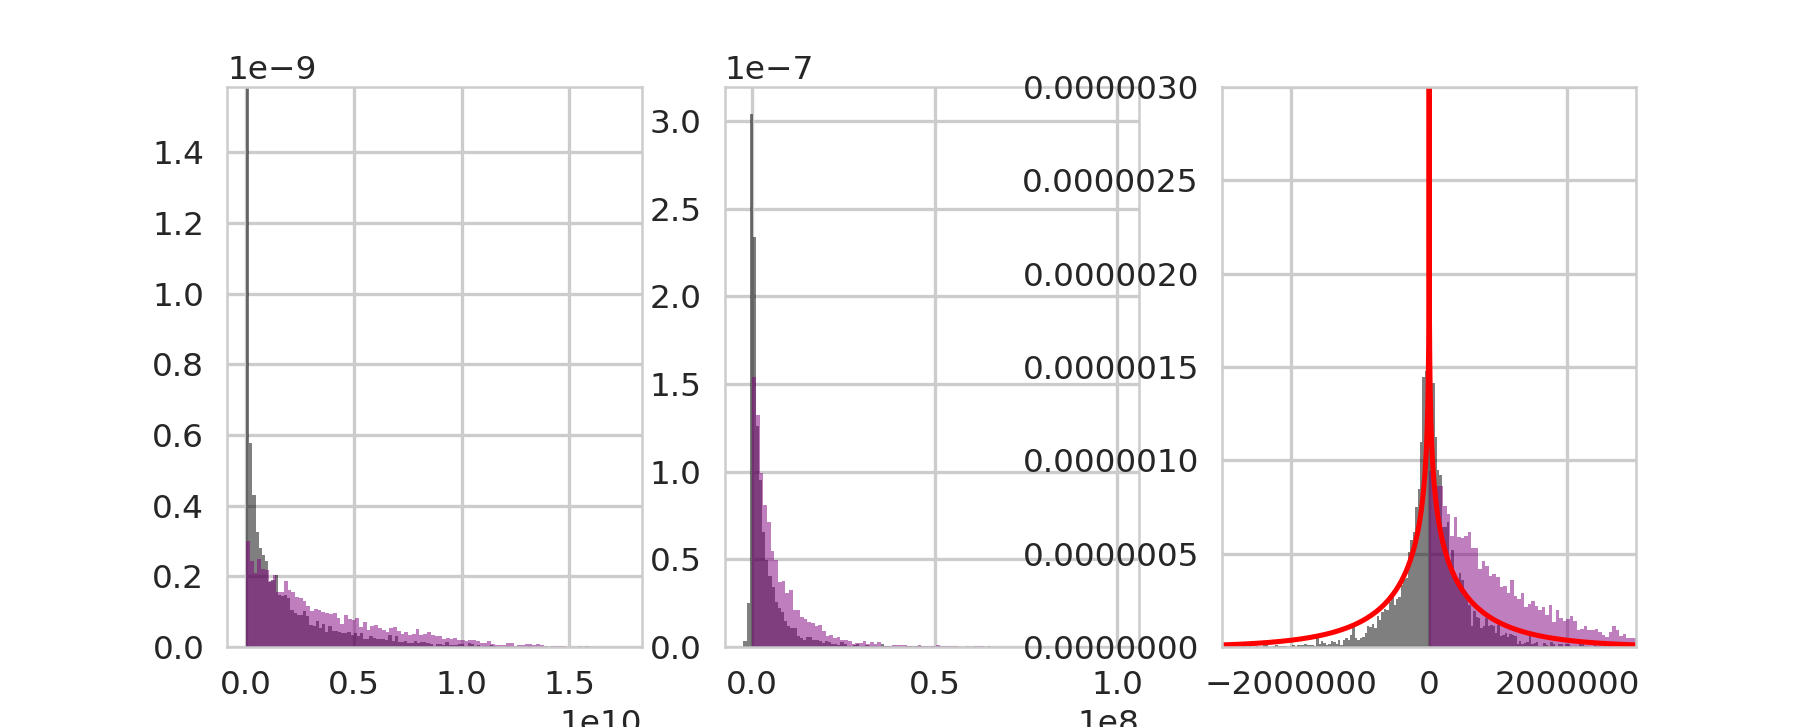

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'norm

(0, 3e-06)

In [314]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
ax1.hist(fourier_squared_test[:, 1].real, bins=100, alpha=0.5, color="black", normed=True)
ax1.hist(fourier_squared_test_lc1[:, 1].real, bins=100, alpha=0.5, color="purple", normed=True)

ax2.hist(fourier_squared_test[:, 50].real, bins=100, alpha=0.5, color="black", normed=True)
ax2.hist(fourier_squared_test_lc1[:, 50].real, bins=100, alpha=0.5, color="purple", normed=True)

ax3.hist(fourier_squared_test[:, 499].real, bins=200, alpha=0.5, color="black", normed=True)
ax3.hist(fourier_squared_test_lc1[:, 499].real, bins=200, alpha=0.5, color="purple", normed=True);
ax3.plot(u, prob_u, lw=2, color="red")
ax3.set_xlim(-3e6, 3e6)
ax3.set_ylim(0, 3e-6)

Okay, so it's definitely not a normal Bessel distribution. It's also not a $\chi^2$ distribution we would expect for a power spectrum. So what *is* it?

I have the suspicion that the two Fourier amplitudes are *correlated* in the red noise case: I don't see how you would otherwise get such a heavily skewed distribution when multipling them. Let's look at the *difference* of Fourier amplitudes:

In [315]:
f1 = fourier1_all[0]
f2 = fourier2_all[0]

In [316]:
f1[:20]

array([ 79443.38421871-12895.02778821j,  42395.31605277-34958.29763234j,
       -40121.05835191-59485.29604637j,  22023.83050245+35833.56279386j,
       -15402.96895472-23941.91500761j,  -1240.7591943  +2965.23600347j,
          226.65288889 -3694.74087282j, -13753.44948226+10409.24813929j,
         9089.57779178 +1426.46577985j,   6273.25869502 -6858.66361401j,
        12361.01279682-12423.34827906j,  -7988.5048903  -1561.0518984j ,
         3785.72602591 +4521.49867762j, -16326.61490652 -5764.2391544j ,
         5985.03825506 -8341.48183301j, -13932.35155998 +3450.73220485j,
         6248.88311329 -5638.28762436j,    778.13298992 -1506.65722885j,
        -3359.61044848 +5362.70104644j,   3329.00692222 -9741.27383016j])

In [317]:
f2[:20]

array([ 79420.38798366-12645.20893718j,  41052.06217609-36667.14688407j,
       -40436.58016185-60915.29945355j,  20741.02485923+36964.17458602j,
       -16540.72973722-24161.57284322j,   -643.47517277 +3634.74492087j,
          314.79992593 -4449.41792212j, -13831.69009563+11337.44417072j,
         9839.59293786  +537.79144484j,   5741.67145364 -5242.6164722j ,
        12427.28659367-11834.48506397j,  -8148.14522091 -2047.03963816j,
         3201.18883423 +1973.241052j  , -17157.26964361 -6073.78763267j,
         4870.50916003 -6113.11491853j, -14157.25771619 +3924.48407875j,
         6050.09877796 -5685.86308966j,   2394.45458935 -1777.8508485j ,
        -2887.93183321 +5018.78013789j,   3912.60843818-10568.30097626j])

In [318]:
f_diff = ([fourier1_all[i].real-fourier2_all[i].real for i in range(5000)])

In [319]:
f_diff = np.array(f_diff)

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


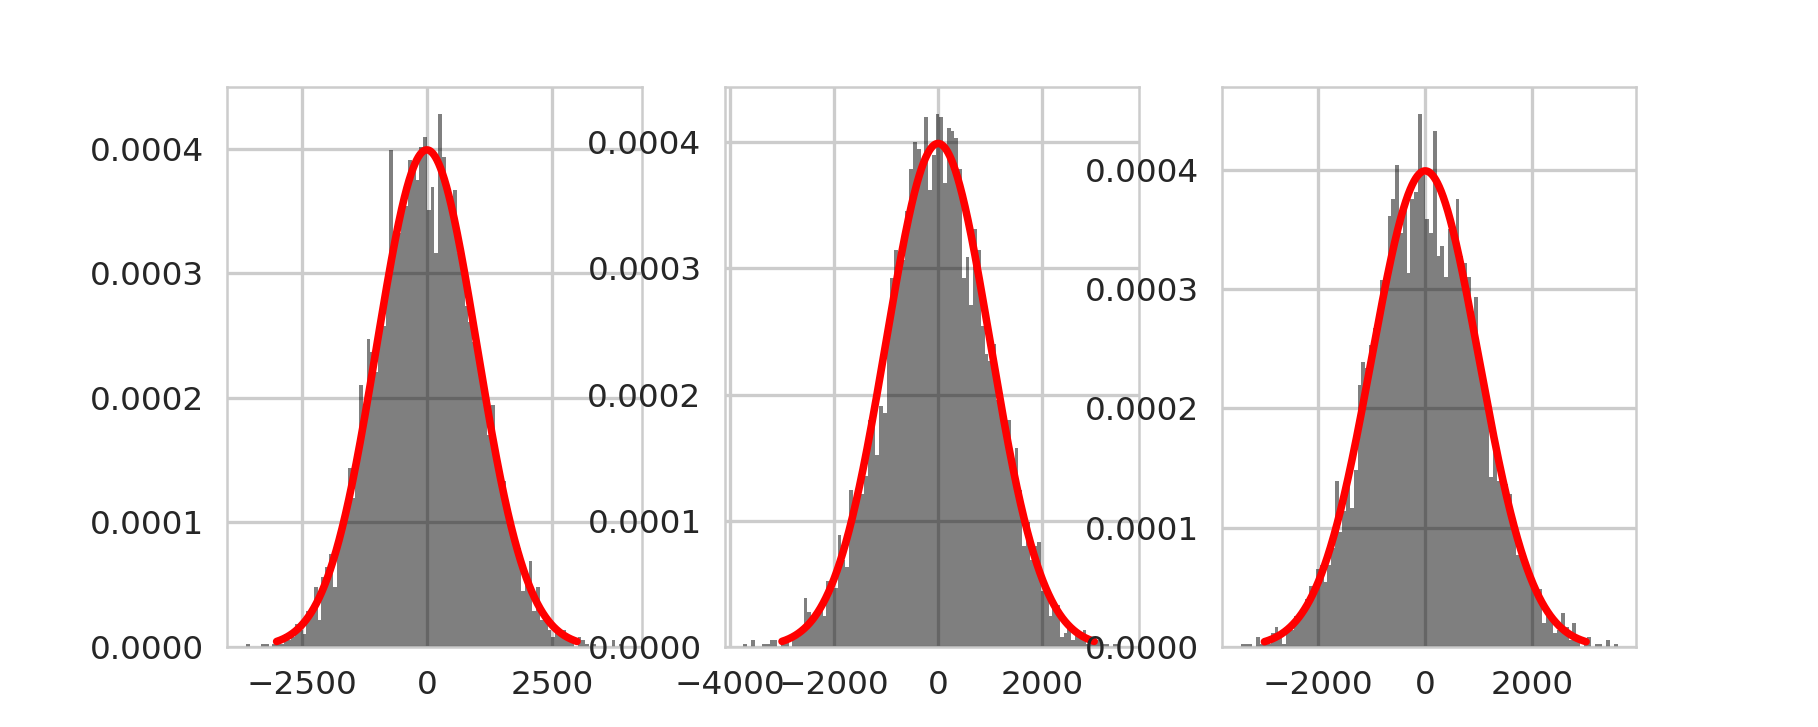

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [320]:
norm1 = scipy.stats.norm(0, np.sqrt(np.mean(lc1_counts_all)))
u = np.linspace(-3000, 3000, 10000)
prob_u = norm1.pdf(u)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
ax1.hist(f_diff[:, 1], bins=100, alpha=0.5, color="black", normed=True)
ax1.plot(u, prob_u, lw=3, color="red")

ax2.hist(f_diff[:, 10], bins=100, alpha=0.5, color="black", normed=True)
ax2.plot(u, prob_u, lw=3, color="red")
#ax2.hist(fourier_squared_test_lc1[:, 10].real, bins=100, alpha=0.5, color="purple")

ax3.hist(f_diff[:, 499], bins=100, alpha=0.5, color="black", normed=True);
ax3.plot(u, prob_u, lw=3, color="red")

#ax3.hist(fourier_squared_test_lc1[:, 499].real, bins=100, alpha=0.5, color="purple");

In [88]:
csd_normed_all = np.array(csd_normed_all)

In [321]:
np.min(csd_normed_all[:,100])

-7.122522621740073

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


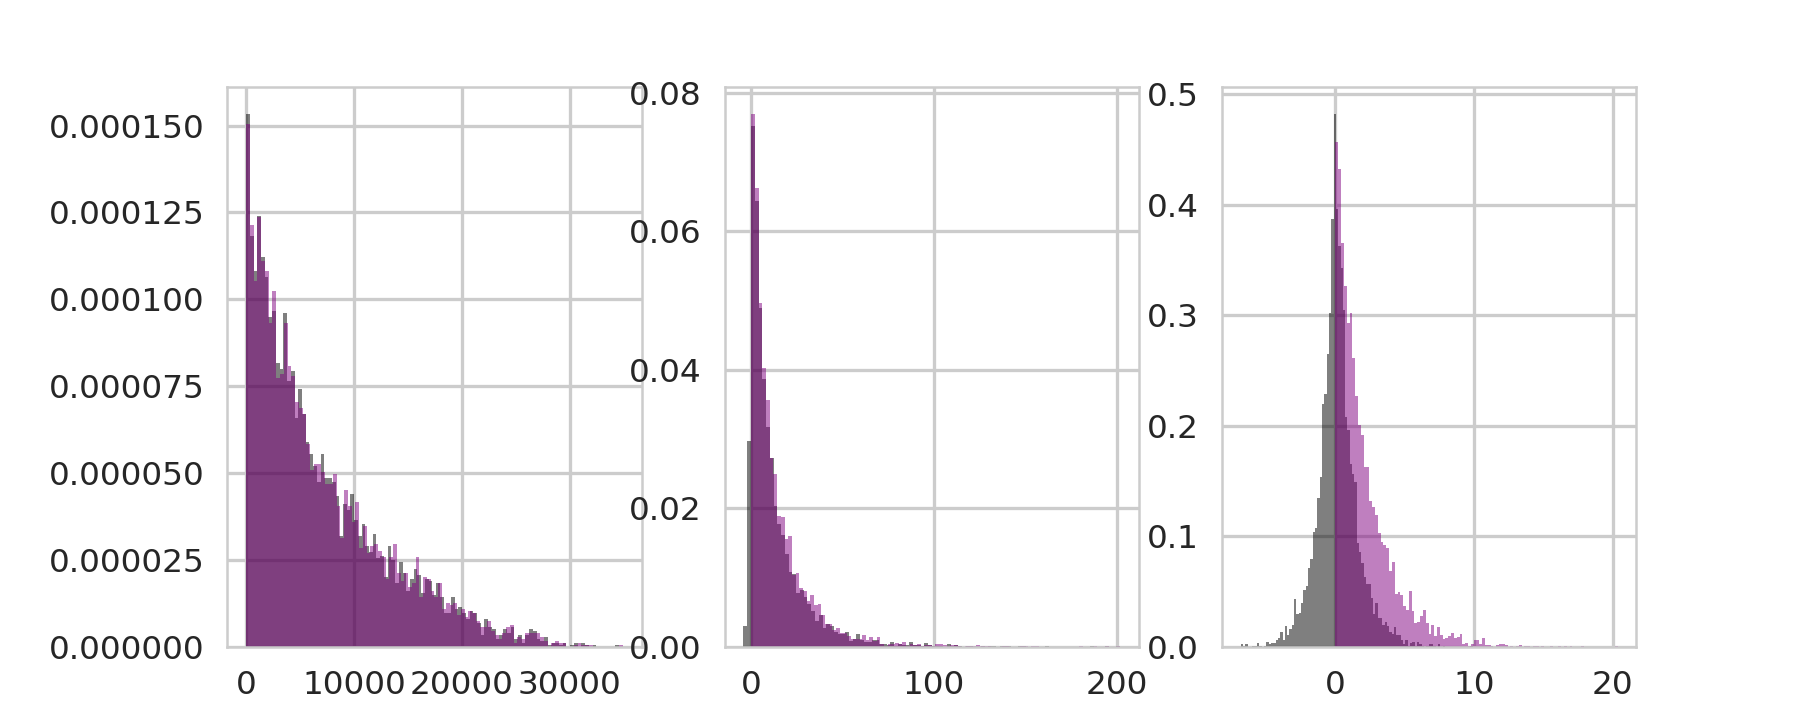

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'norm

In [322]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
ax1.hist(csd_normed_all[:, 1], bins=100, alpha=0.5, color="black", normed=True)
p = np.array([ps.power[1] for ps in ps1_all])

ax1.hist(p, bins=100, alpha=0.5, color="purple", normed=True)

ax2.hist(csd_normed_all[:, 50].real, bins=100, alpha=0.5, color="black", normed=True)
ax2.hist([ps.power[50] for ps in ps1_all], bins=100, alpha=0.5, color="purple", normed=True)
#ax2.set_xlim(0, 500)

ax3.hist(csd_normed_all[:, 499].real, bins=100, alpha=0.5, color="black", normed=True)
ax3.hist([ps.power[499] for ps in ps1_all], bins=100, alpha=0.5, color="purple", normed=True);



<IPython.core.display.Javascript object>


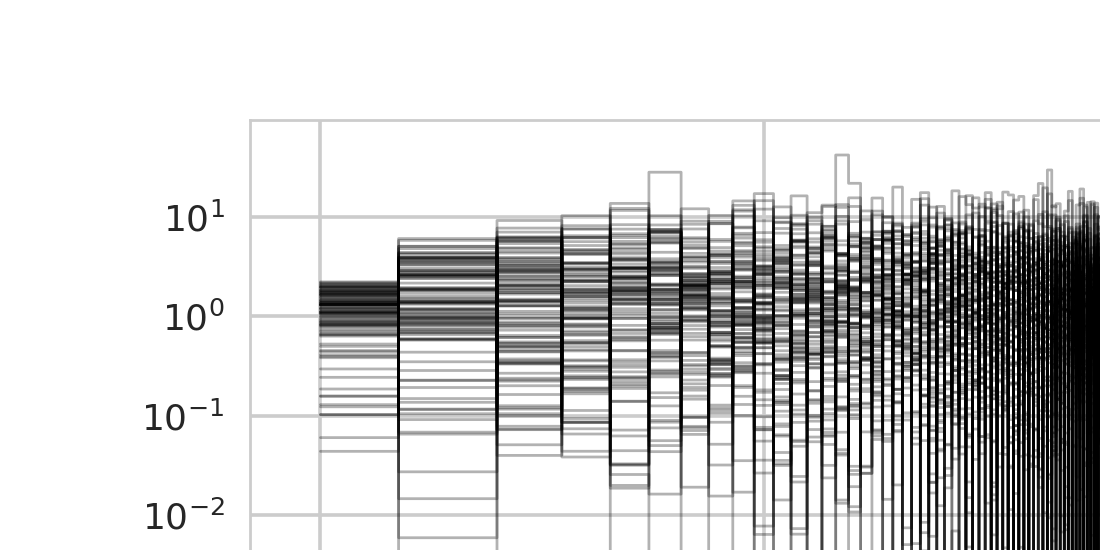

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
for cs in csd_normed_all[:100]:
    ax.loglog(freqs[:1500], 2*cs/mps[:1500], lw=1, color="black", linestyle="steps-mid", alpha=0.3)

What's the correlation coefficient between the Fourier amplitudes?

In [323]:
np.cov(fourier1_all[-1].real, fourier2_all[-1].real)

array([[11658224.31082335, 11043110.01726565],
       [11043110.01726565, 11398022.94961025]])

In [324]:
cov_all = []
for i in range(1500):
    cov_all.append(np.cov(fourier1_all[:,i].real, fourier2_all[:,i].real))

In [325]:
cov_all = np.array(cov_all)

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


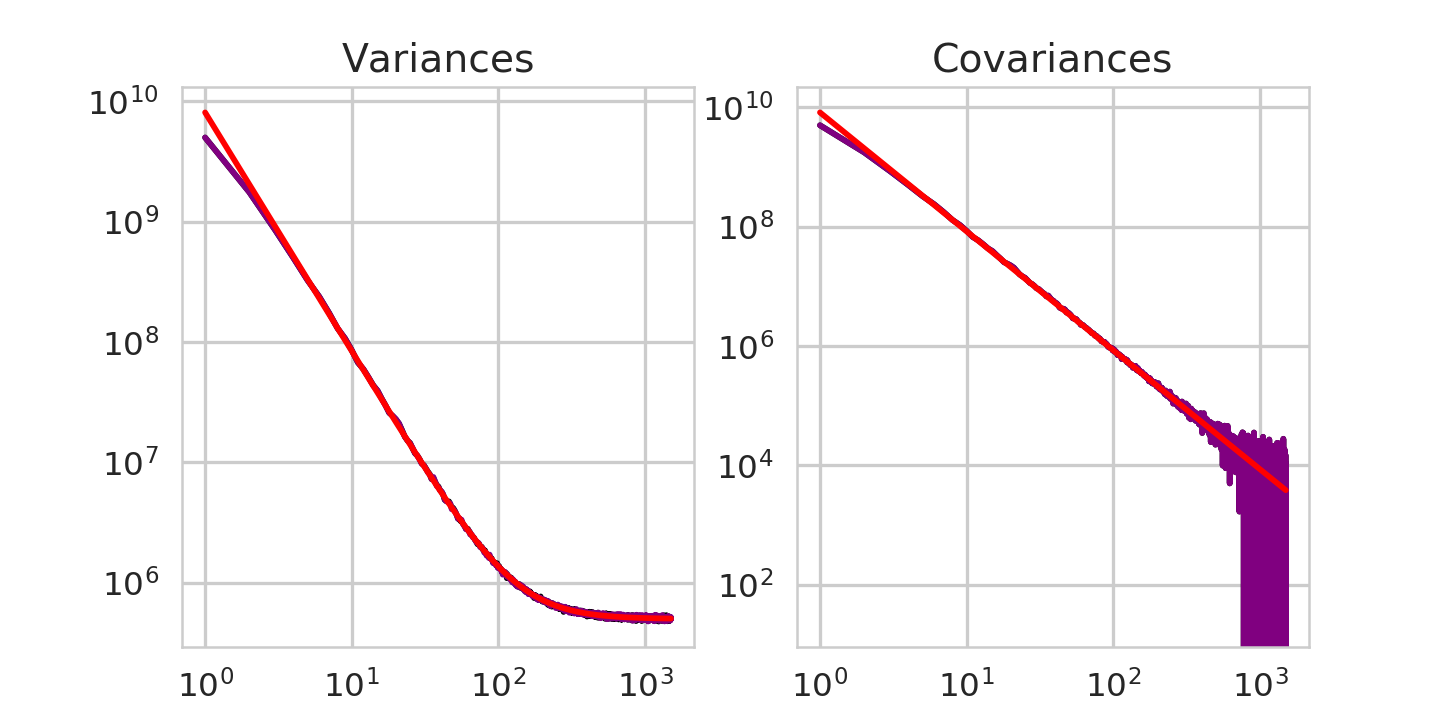

Text(0.5,1,'Covariances')

In [326]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.loglog(avg_ps1.freq[:1500], cov_all[:,0,0], color="black")
ax1.loglog(avg_ps1.freq[:1500], cov_all[:,1,1], color="purple")
ax1.loglog(avg_ps1.freq[:1500], mps[:1500]*np.mean(lc1_counts_all)/4.0, color="red")
ax1.set_title("Variances")

ax2.loglog(avg_ps1.freq[:1500], cov_all[:,0,1], color="black")
ax2.loglog(avg_ps1.freq[:1500], cov_all[:,1,0], color="purple")
ax2.loglog(avg_ps1.freq[:1500], mps_rn[:1500]*np.mean(lc1_counts_all)/4.0, color="red")
ax2.set_title("Covariances")



Okay, so the *variances* match the *overall* power spectrum (including the white noise plus the red noise), while the *covariances* match the red noise *only*, as I would expect.

Therefore, the correlation coefficient must be something like the ratio of the two!

In [327]:
corr_coeff_real, corr_coeff_imag = [], []
for i in range(1500):
    corr_coeff_real.append(np.corrcoef(fourier1_all[:,i].real, fourier2_all[:,i].real)[0,1])
    corr_coeff_imag.append(np.corrcoef(fourier1_all[:,i].imag, fourier2_all[:,i].imag)[0,1])

I think I should be able to calculate this by hand. 

In [328]:
np.mean(lc1_counts_all)

1000015.2338

In [329]:
def calculate_r(mpower):
    return (mpower / (mpower + 2))

In [330]:
m2 = models.PowerLaw1D()

In [331]:
m2.alpha = m.alpha_0
m2.amplitude = m.amplitude_0

pl_model = m2(freqs)

In [332]:
rtest = calculate_r(pl_model[:1500])

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


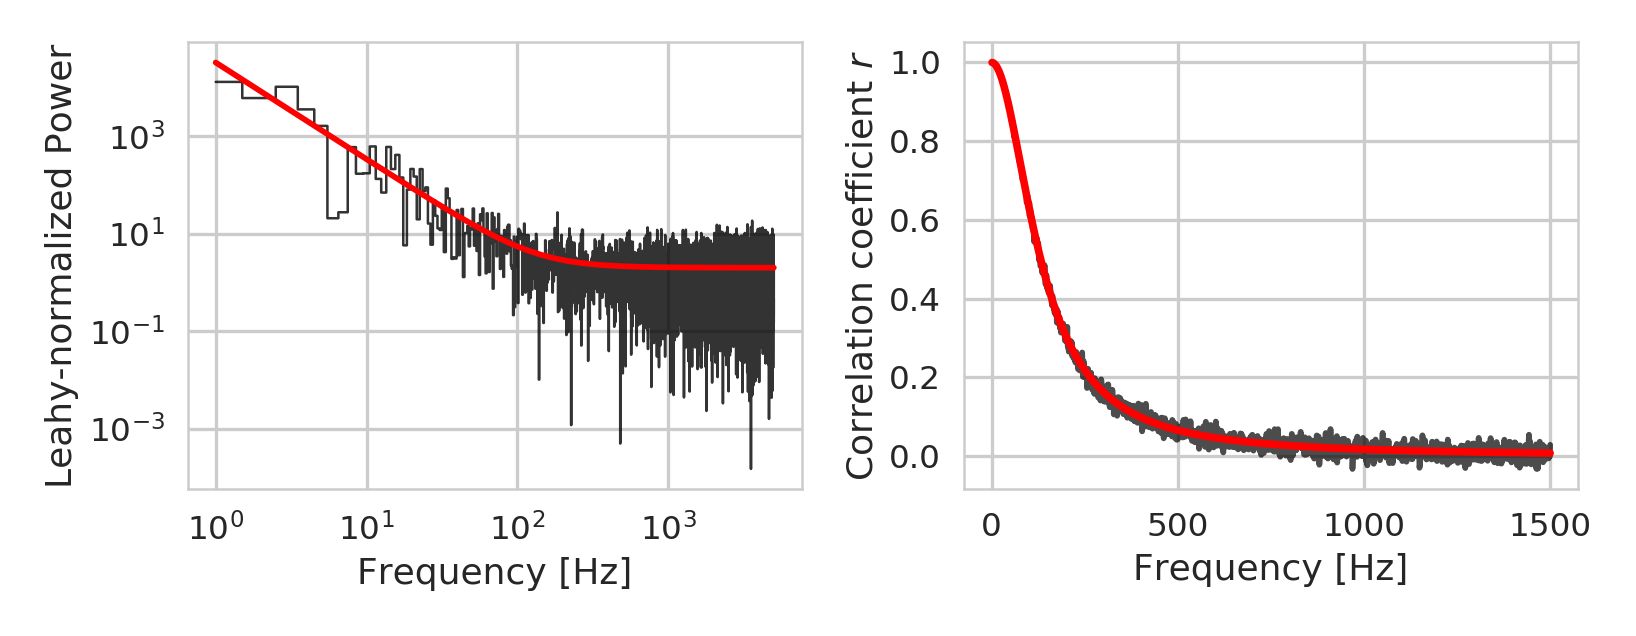

In [333]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,3.5))

ax1.loglog(ps1_all[0].freq, ps1_all[0].power, linestyle="steps-mid", 
           color="black", lw=1, alpha=0.8, label="Simulated data")
ax1.loglog(avg_ps1.freq, mps, color="red", label="True power spectrum")

ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Leahy-normalized Power")

ax2.plot(freqs[:1500], corr_coeff_real, color="black", alpha=0.7, label="Simulated coefficient");
#ax2.plot(freqs[:500], corr_coeff_imag, color="purple", alpha=0.7);
ax2.plot(freqs[:1500], rtest, color="red", lw=3, label="theoretical prediction")

ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel(r"Correlation coefficient $r$")

plt.tight_layout()

plt.savefig("../figs/rednoise_psd.pdf", format="pdf")

For red noise, the higher the power, the more correlated the variables are. That makes sense. This means I kind of understand how to calculate the distribution of the squared variables in *principle*. 

I don't know how to determine the correlation coefficient in practice.

In [334]:
def bessel_probability_corr(x, std1, std2, corr):
    x_abs = np.abs(x)
    both_std = std1 * std2
    corr_fac = (1.0 - corr**2.0)
    
    log_pre_fac = -np.log(np.pi) - np.log(std1) - np.log(std2) - 0.5*np.log(corr_fac)
    
    log_exp_fac = corr * x / (both_std * corr_fac)
    
    logy = np.log(x_abs) - np.log(std1) - np.log(std2) - np.log(corr_fac)
    
    order = 0
    log_bessel = np.log(scipy.special.kn(order, np.exp(logy)))

    return np.exp(log_pre_fac + log_exp_fac + log_bessel)


In [335]:
corr_coeff_real[50]

0.8692930726938991

Let's get the standard deviations for each bin:

In [336]:
std1, std2 = [], []
for i in range(500):
    std1.append(np.std(fourier1_all[:,i].real))
    std2.append(np.std(fourier2_all[:,i].real))

Do I know what the standard deviations are?

In [337]:
std1 = np.array(std1)
std2 = np.array(std2)

In [338]:
std1[0]

70817.42979392462

In [339]:
model_var = (mps_rn[:1500]+2)*np.mean(lc1_counts_all)/4
model_std = np.sqrt(model_var)

In [340]:
np.sqrt(model_var)[0]

90715.46100173282

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


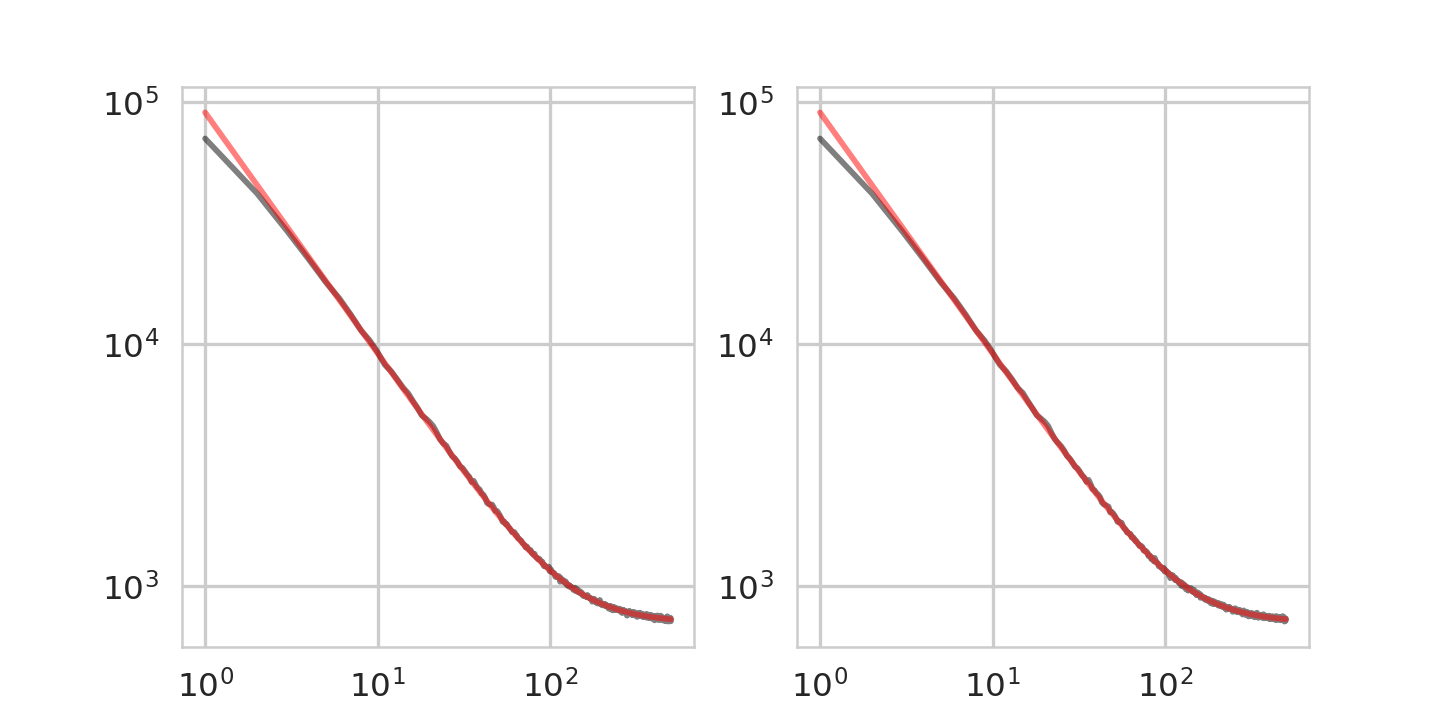

In [341]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.plot(avg_ps1.freq[:500], std1, color="black", alpha=0.5)
ax1.plot(avg_ps1.freq[:500], np.sqrt(model_var[:500]), color="red", alpha=0.5)

ax2.plot(avg_ps1.freq[:500], std2, color="black", alpha=0.5)
ax2.plot(avg_ps1.freq[:500], np.sqrt(model_var[:500]), color="red", alpha=0.5)

ax1.set_xscale("log")
ax1.set_yscale("log")

ax2.set_xscale("log")
ax2.set_yscale("log")

In [293]:
x1 = np.linspace(-1e9, 2e9, 10000)
bprob1 = bessel_probability_corr(x1, model_std[10], model_std[10], corr_coeff_real[10])


x2 = np.linspace(-1e6, 2e7, 10000)
bprob2 = bessel_probability_corr(x2, model_std[50],model_std[50], corr_coeff_real[50])


x3 = np.linspace(-2500000, 2500000, 10000)
bprob3 = bessel_probability_corr(x3, model_std[499], model_std[499], corr_coeff_real[499])


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: floating point number truncated to an integer
  del sys.path[0]
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in add
  from ipykernel import kernelapp as app


In [342]:
freqs[499]

500.0000000000551

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


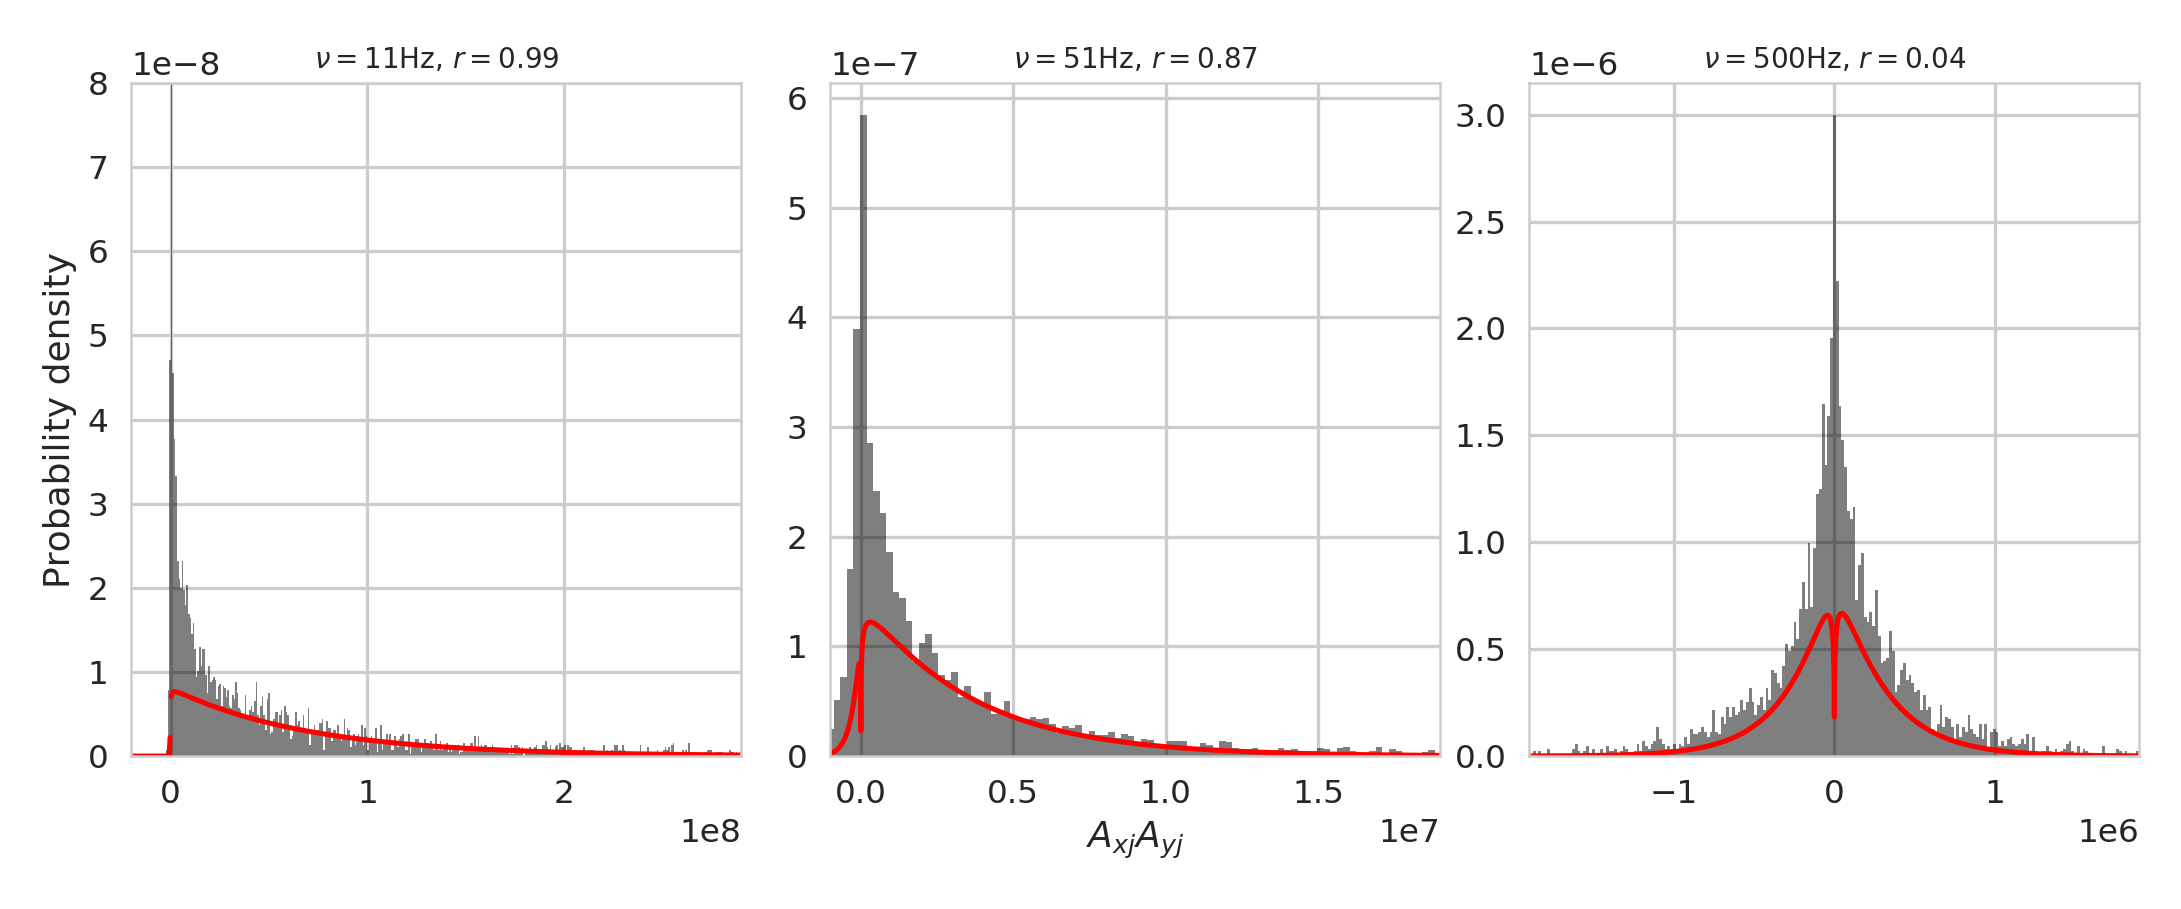

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


In [343]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))
ax1.hist(fourier_squared_test[:, 10].real, bins=400, range=[-2e7, 3e8], alpha=0.5, color="black", normed=True)
#ax1.hist(fourier_squared_test_lc1[:, 1].real, bins=100, alpha=0.5, color="purple")
ax1.plot(x1, bprob1, lw=2, color="red")
ax1.set_xlim(-2e7,2.9e8)
ax1.set_ylim(0, 8e-8)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax1.set_title(r"$\nu = 11 \mathrm{Hz}$, $r = %.2f$"%corr_coeff_real[10], fontsize=11)

ax2.hist(fourier_squared_test[:, 50].real, bins=400, alpha=0.5, color="black", normed=True)
#ax2.hist(fourier_squared_test_lc1[:, 10].real, bins=100, alpha=0.5, color="purple")
ax2.plot(x2, bprob2, lw=2, color="red")
ax2.set_xlim(-1e6, 1.9e7)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax2.set_title(r"$\nu = 51 \mathrm{Hz}$, $r = %.2f$"%corr_coeff_real[50], fontsize=11)


ax2.set_xlabel(r"$A_{xj}A_{yj}$")
ax1.set_ylabel("Probability density")

ax3.hist(fourier_squared_test[:, 499].real, bins=400, 
         alpha=0.5, color="black", normed=True)
ax3.plot(x3, bprob3, lw=2, color="red")
ax3.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax3.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax3.set_xlim(-1.9e6, 1.9e6)

ax3.set_title(r"$\nu = 500 \mathrm{Hz}$, $r = %.2f$"%corr_coeff_real[499], fontsize=11)

plt.tight_layout(w_pad=0.35)
plt.savefig("../figs/rednoise_bessel.pdf", format="pdf")

Okay, this seems to work in principle. It just gets really dicey for very high values of the correlation.

## Two Solutions for Cospectral distributions

There are two possible solutions to this problem for cospectra. [This paper](https://www.sciencedirect.com/science/article/pii/S1631073X15002873) and [this paper](https://onlinelibrary.wiley.com/doi/full/10.1111/stan.12152) derive the exact distribution for the product of two correlated Gaussian variables, based on [Cui et al (2016)](https://ieeexplore.ieee.org/abstract/document/7579552). This in itself doesn't help, but they *also* derive the *mean* of $n$ IID variables, and the cospectrum can be considered as the sum of two IID variables with the distribution given in those papers.

Using these results, we have for the distribution of the mean

$$
f_Z(z) = \frac{2 |z|^{(1/2)}}{\sqrt{\pi(1 - \rho^2)}} \exp{\left(\frac{\beta - \gamma}{2} z \right)} K_{-1/2}\left(\frac{\beta + \gamma}{2} |z| \right)
$$

with 

$$
\beta = \frac{2}{1 - \rho} \;\;\; , \;\;\; \gamma = \frac{2}{1 + \rho}
$$

where $\rho$ is the correlation coefficient:

$$
\rho = \frac{P_j}{P_j + 2}
$$

with $P_j = P(\nu_j)$ is the power spectrum at frequency $\nu_j$.

Let's try to code this into a function:

In [81]:
from scipy.special import kv

In [216]:
def cospectra_probability_corr(x, std1, std2, corr):
    x_abs = np.abs(x)
    both_std = std1 * std2
    corr_fac = (1.0 - corr**2.0)
    
    first_term = np.log(2) + np.log(x_abs**0.5) -  np.log(both_std**1.5 * np.sqrt(np.pi * corr_fac))
    #print(first_term)
    
    second_term = (2 * corr * x / (both_std*corr_fac))
    #print(second_term)
    
    y = np.log(2) + np.log(x_abs) - np.log(both_std) - np.log(corr_fac)
    
    order = 1
    third_term = np.log(scipy.special.kv(order, np.exp(y)))
    #print(third_term)
    
    return np.exp(first_term + second_term + third_term)
    
    #log_pre_fac = np.log(2.) + 0.5* np.log(x_abs) - 1.5* np.log(both_std) - np.log(np.pi) - 0.5*np.log(corr_fac)
    
    #log_exp_fac = 2. * corr * x / (both_std * corr_fac)
    
    #logy = np.log(2.) + np.log(x_abs) - np.log(std1) - np.log(std2) - np.log(corr_fac)
    
    #order = 0.5
    #log_bessel = np.log(scipy.special.kn(order, np.exp(logy)))

    return np.exp(log_pre_fac + log_exp_fac + log_bessel)


In [232]:
x = np.linspace(-100, 100, 1000)

probs = cospectra_probability_corr(x, model_std[499], model_std[499], corr_coeff_real[499])


In [233]:
np.sum(probs)

0.15207834624514535

In [236]:
csd_all.shape

(5000, 1500)

<IPython.core.display.Javascript object>


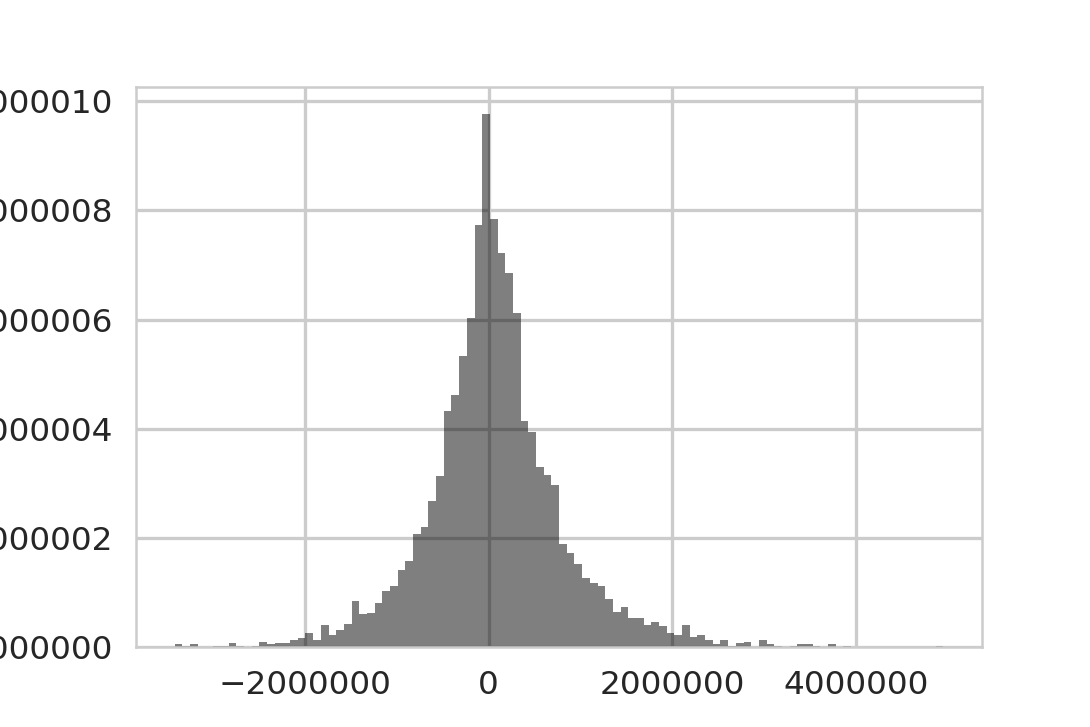

(array([4.77898104e-09, 2.38949052e-09, 4.77898104e-09, 0.00000000e+00,
        0.00000000e+00, 2.38949052e-09, 2.38949052e-09, 7.16847156e-09,
        2.38949052e-09, 0.00000000e+00, 2.38949052e-09, 9.55796207e-09,
        4.77898104e-09, 7.16847156e-09, 7.16847156e-09, 1.19474526e-08,
        1.67264336e-08, 2.62843957e-08, 1.19474526e-08, 4.06213388e-08,
        2.15054147e-08, 3.10633767e-08, 4.30108293e-08, 8.36321681e-08,
        5.97372630e-08, 6.21267535e-08, 8.12426776e-08, 1.02748092e-07,
        1.12306054e-07, 1.40979941e-07, 1.57706374e-07, 2.07885675e-07,
        2.19833128e-07, 2.67622938e-07, 3.13023258e-07, 4.32497784e-07,
        4.61171670e-07, 5.32856386e-07, 6.02151611e-07, 7.74194928e-07,
        9.77301622e-07, 7.83752890e-07, 7.21626137e-07, 6.85783779e-07,
        6.11709573e-07, 4.13381860e-07, 3.94265936e-07, 3.29749692e-07,
        3.15412748e-07, 2.96296824e-07, 1.88769751e-07, 1.72043317e-07,
        1.52927393e-07, 1.26642997e-07, 1.17085035e-07, 1.123060

In [240]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))


ax.hist(csd_all[:,499], bins=100, histtype="stepfilled", alpha=0.5, color="black", 
        density=True);
#ax.plot(x, probs)

This doesn't seem to work. Let's simulate some cross-correlated random numbers and see what they look like:

In [251]:
rmeans = [0,0]
rstd1 = 1.
rstd2 = 2.0
rcov = 0.5

rsim1 = np.random.multivariate_normal(rmeans, [[rstd1, rcov], [rcov, rstd2]], size=50000)
rsim2 = np.random.multivariate_normal(rmeans, [[rstd1, rcov], [rcov, rstd2]], size=50000)

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


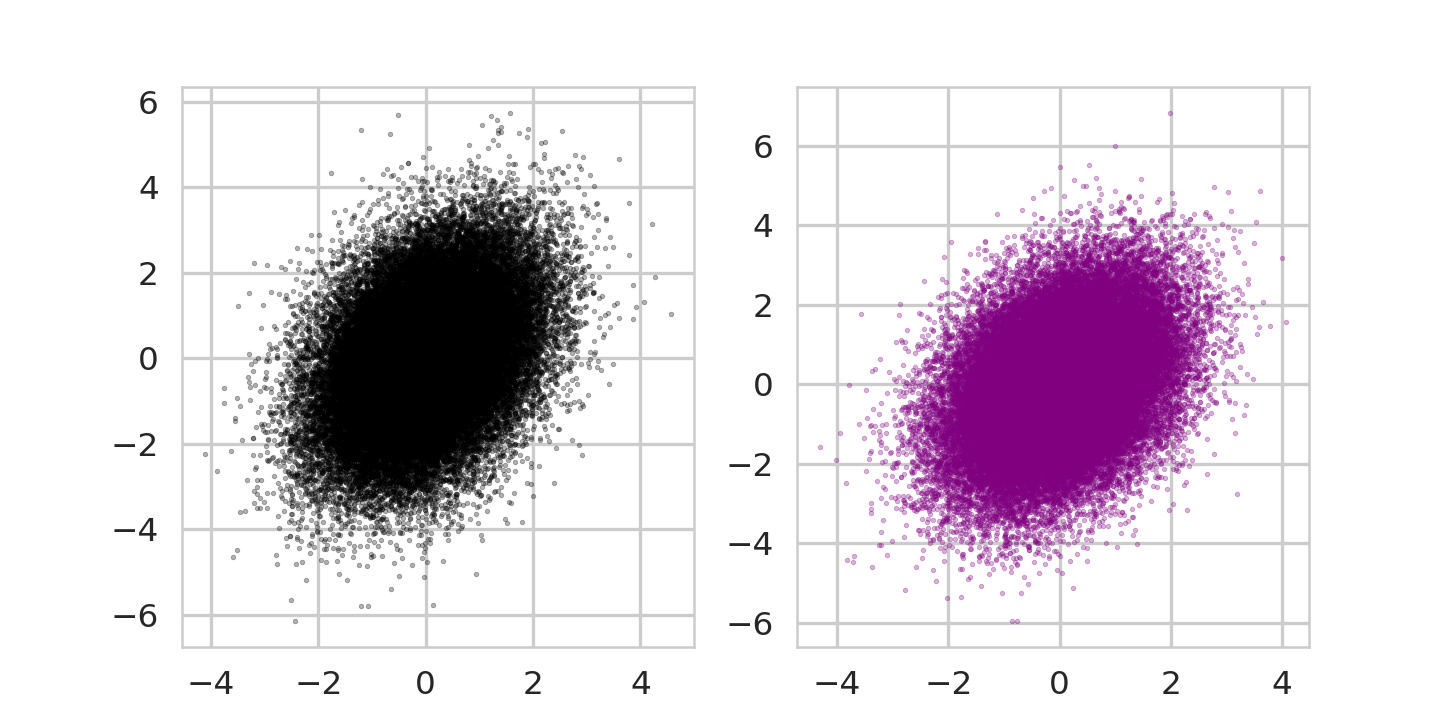

In [253]:
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(8,4))

ax1.scatter(rsim1[:,0], rsim1[:,1], s=3, c="black", alpha=0.3)
ax2.scatter(rsim2[:,0], rsim2[:,1], s=3, c="purple", alpha=0.3)

In [272]:
np.var(rsim1[:,0])

0.9980179596911697

In [273]:
np.var(rsim1[:,1])

2.0228348079279166

In [255]:
np.cov(rsim1[:,0], rsim1[:,1])

array([[0.99803792, 0.50503333],
       [0.50503333, 2.02287527]])

In [260]:
rcoeff = np.corrcoef(rsim1[:,0], rsim1[:,1])

In [258]:
rmult1 = rsim1[:,0] * rsim1[:,1]
rmult2 = rsim2[:,0] * rsim2[:,1]

Let's calculate the theoretical expectation for that:

In [284]:
model_std[499]

730.8953050171436

In [285]:
corr_coeff_real[499]

0.04294672051147352

In [291]:
x = np.linspace(-100, 100, 10000)

bprob = bessel_probability_corr(x, 500, 500, 0.04)

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: floating point number truncated to an integer
  del sys.path[0]


/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


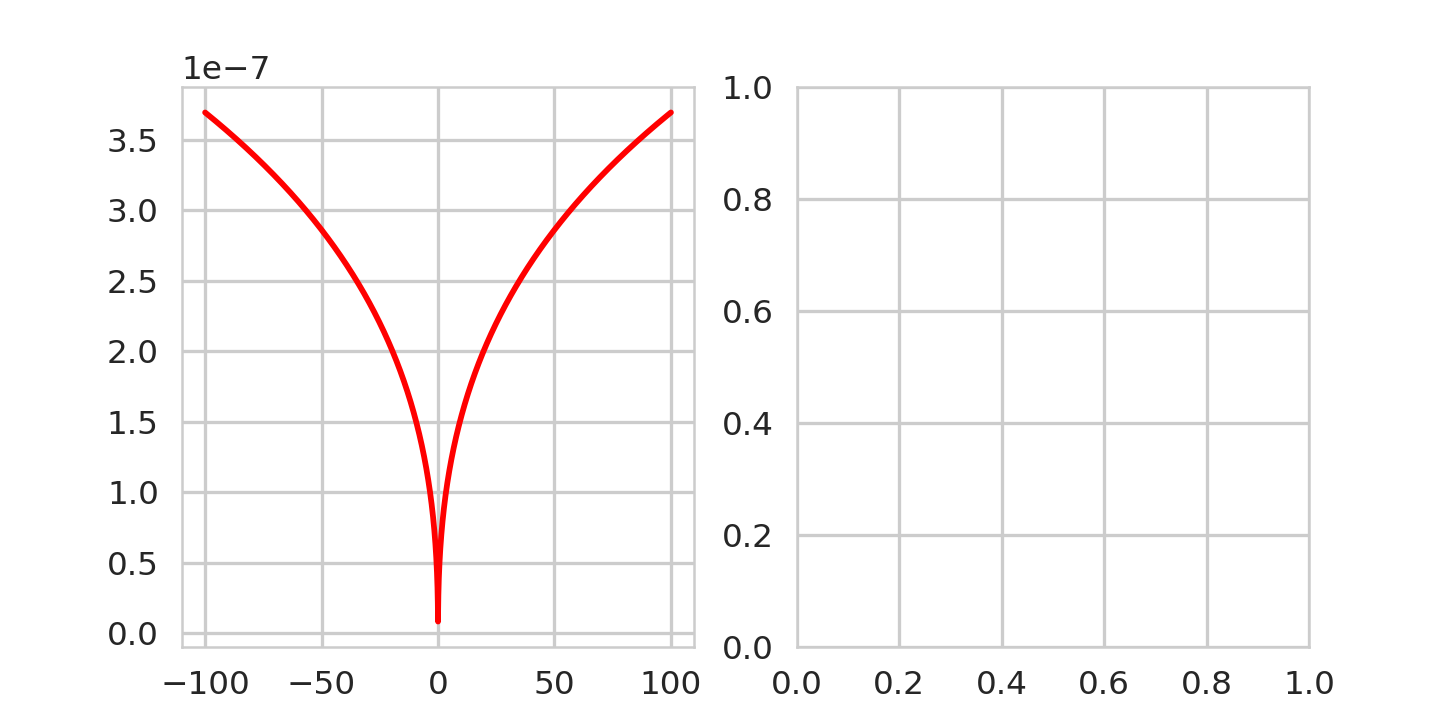

In [292]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

#ax1.hist(rmult1, bins=100, histtype="stepfilled", color="black", alpha=0.5, density=True)
#ax2.hist(rmult2, bins=100, histtype="stepfilled", color="purple", alpha=0.5, density=True)

ax1.plot(x, bprob, color="red")

In [ ]:
csd_all

In [223]:
np.sum(probs)

0.3400575613221942

This doesn't work, so let's try a log-version:

In [139]:
from scipy.special import iv
import mpmath

In [108]:
pmodel = mps[10]
pobs = 1000

In [184]:
def log_cospectra_var_prob(pobs, pmodel, nphot):
    """
    Probability density for a single cospectrum, 
    following Nadarajaha + Pogány (2016) and Gaunt (2018).
    
    Parameters
    ----------
    pobs : float
        The observed value of the periodogram at a frequency f_j
        
    pmodel : float
        The value of a power spectral model at a frequency f_j
        
    Returns
    -------
    prob : float
        The probability density of observing `pobs` given `pmodel`
    
    """
    # calculate the correlation coefficient
    rho = pmodel/(pmodel + 2)
    #print("rho: " + str(rho))
    
    # product of the standard deviations
    sigma2 = (nphot/4.) * (pmodel + 2)
    
    # absolute value of pobs:
    abs_p = np.abs(pobs)
    
    #first_term = 2. * np.sqrt(abs_p) / ((sigma2**1.5) * np.sqrt(np.pi * (1. - rho**2.)))
    first_term = np.log(2.) + 0.5*np.log(abs_p) - 1.5 * np.log(sigma2) - 0.5 * np.log(np.pi * (1-rho**2.))
    print("first_term: " + str(first_term))
    
    #second_term = np.exp(2. * rho * pobs / (sigma2 * (1. - rho**2.)))
    second_term = 2. * rho * pobs / (sigma2 * (1 - rho**2.))
    print("second_term: " + str(second_term))
    
    bessel_arg = 2. * abs_p / (sigma2 * (1 - rho**2.))
    print("bessel_arg: " + str(bessel_arg))
    
    third_term = np.log(kv(0.5, bessel_arg))
    print("third_term: " + str(third_term))
    
    prob = first_term + second_term + third_term
    print("prob: " + str(prob))
    
    return prob
    

In [185]:
log_cospectra_var_prob(100, mps[3000], mean_nphot)

first_term: -18.156234830170575
second_term: 0.00013343576168231314
bessel_arg: 0.0002667078907345115
third_term: 4.3402029150829335
prob: -13.81589847932596


-13.81589847932596

In [194]:
idx = 1400

In [195]:
csd_normed_all.shape

(5000, 1500)

In [196]:
x = np.linspace(np.min(csd_normed_all[:,idx]), np.max(csd_normed_all[:,idx]), 1000)

probs = np.zeros_like(x)

for i,p in enumerate(x):
    probs[i] = log_cospectra_var_prob(p, mps[idx], mean_nphot)

first_term: -19.411967564048158
second_term: -1.0943879760796135e-05
bessel_arg: 2.179724469727956e-05
third_term: 5.592633048495116
prob: -13.819345459432803
first_term: -19.412922169435777
second_term: -1.0923005520636715e-05
bessel_arg: 2.17556688639764e-05
third_term: 5.593587695458569
prob: -13.81934539698273
first_term: -19.41387860085312
second_term: -1.0902131280477293e-05
bessel_arg: 2.1714093030673242e-05
third_term: 5.594544168451746
prob: -13.819345334532654
first_term: -19.41483686529947
second_term: -1.0881257040317873e-05
bessel_arg: 2.167251719737008e-05
third_term: 5.5955024744739275
prob: -13.819345272082582
first_term: -19.415796969814426
second_term: -1.086038280015845e-05
bessel_arg: 2.1630941364066923e-05
third_term: 5.596462620564717
prob: -13.81934520963251
first_term: -19.416758921478223
second_term: -1.0839508559999028e-05
bessel_arg: 2.1589365530763758e-05
third_term: 5.597424613804346
prob: -13.819345147182435
first_term: -19.417722727412034
second_term: -1.

third_term: 5.938953621920756
prob: -13.819329097513556
first_term: -19.760187271065647
second_term: -5.453954598868319e-06
bessel_arg: 1.0862800538548468e-05
third_term: 5.940863689956763
prob: -13.819329035063483
first_term: -19.762104621916478
second_term: -5.433080358708899e-06
bessel_arg: 1.0821224705245308e-05
third_term: 5.942781082383428
prob: -13.819328972613407
first_term: -19.764029353548054
second_term: -5.412206118549478e-06
bessel_arg: 1.0779648871942149e-05
third_term: 5.944705855590836
prob: -13.819328910163335
first_term: -19.765961523004187
second_term: -5.391331878390056e-06
bessel_arg: 1.073807303863899e-05
third_term: 5.946638066622803
prob: -13.819328847713262
first_term: -19.767901187992578
second_term: -5.370457638230634e-06
bessel_arg: 1.0696497205335828e-05
third_term: 5.948577773187026
prob: -13.819328785263192
first_term: -19.769848406895136
second_term: -5.349583398071213e-06
bessel_arg: 1.0654921372032669e-05
third_term: 5.950525033665418
prob: -13.8193287

third_term: 6.908525477738453
prob: -13.819313499238756
first_term: -20.714757958696023
second_term: 8.083174489580862e-07
bessel_arg: 1.6099494523995434e-06
third_term: 6.895443630438223
prob: -13.819313519940351
first_term: -20.70200971169474
second_term: 8.291916891175073e-07
bessel_arg: 1.6515252857027029e-06
third_term: 6.882695341861108
prob: -13.819313540641943
first_term: -20.68957843539864
second_term: 8.500659292769283e-07
bessel_arg: 1.6931011190058624e-06
third_term: 6.8702640239891775
prob: -13.819313561343533
first_term: -20.67744874922127
second_term: 8.709401694363494e-07
bessel_arg: 1.7346769523090219e-06
third_term: 6.858134296235972
prob: -13.819313582045128
first_term: -20.665606365593952
second_term: 8.918144095957727e-07
bessel_arg: 1.776252785612186e-06
third_term: 6.84629187103282
prob: -13.819313602746723
first_term: -20.6540379887911
second_term: 9.126886497551939e-07
bessel_arg: 1.8178286189153456e-06
third_term: 6.834723452654135
prob: -13.819313623448316
fi

bessel_arg: 1.5995187775292916e-05
third_term: 5.7473866799605835
prob: -13.819320682691576
first_term: -19.565417443914008
second_term: 8.051678784277295e-06
bessel_arg: 1.6036763608596077e-05
third_term: 5.746088688842054
prob: -13.81932070339317
first_term: -19.564122854995382
second_term: 8.072553024436719e-06
bessel_arg: 1.607833944189924e-05
third_term: 5.744794058347596
prob: -13.81932072409476
first_term: -19.56283160934325
second_term: 8.09342726459614e-06
bessel_arg: 1.61199152752024e-05
third_term: 5.743502771119626
prob: -13.819320744796357
first_term: -19.561543689734144
second_term: 8.11430150475556e-06
bessel_arg: 1.616149110850556e-05
third_term: 5.7422148099346915
prob: -13.819320765497949
first_term: -19.56025907907738
second_term: 8.135175744914982e-06
bessel_arg: 1.620306694180872e-05
third_term: 5.740930157702092
prob: -13.819320786199544
first_term: -19.55897776041364
second_term: 8.156049985074403e-06
bessel_arg: 1.624464277511188e-05
third_term: 5.73964879746251

/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


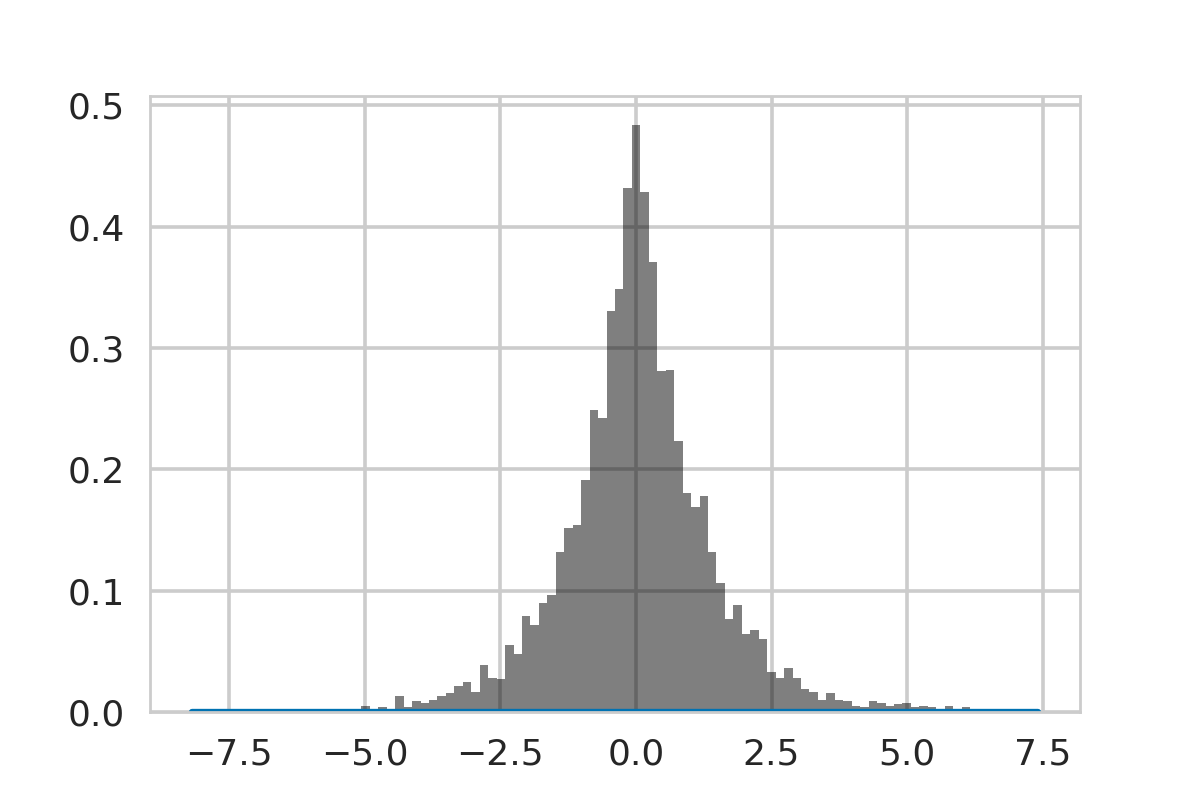

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(csd_normed_all[:,idx], bins=100, histtype="stepfilled", 
        color="black", alpha=0.5, range=[np.min(csd_normed_all[:,idx]), 
                                         np.max(csd_normed_all[:,idx])],
       density=True);

ax.plot(x, np.exp(probs))

In [288]:
pmodel = mps[1400]
rho = pmodel/(pmodel + 2)

In [292]:
rho = 0.5

In [295]:
(4/3)**2

1.7777777777777777

In [296]:
(4/3)**3

2.37037037037037

In [293]:
def compute_delta(k, rho):
    
    delta_all = np.zeros(k)
    delta_zero = 1.0
    
    gamma = (1.0 - (rho-1)/(rho+1))
    print(gamma)
    
    for i in range(0, k, 1):
        if i == 0:
            delta_all[i] = delta_zero
        else:
            idx = np.arange(1, i+1, 1, dtype=float)
            print(idx)
            delta_all[i] = np.sum(idx * (gamma**idx)/idx * delta_all[:i][::-1])
    return delta_all
        

In [294]:
compute_delta(5, rho)

1.3333333333333333
[1.]
[1. 2.]
[1. 2. 3.]
[1. 2. 3. 4.]


array([ 1.        ,  1.33333333,  3.55555556,  9.48148148, 25.28395062])

#### Using the Moment-Generating Function

In Craig (1936), there is actually a derivation using moment-generating functions for the general case of 

